In [651]:
import pyspark as py
import os
from pyspark.sql.functions import when, col, isnan
from pyspark.sql import SparkSession

# Running Context

In [652]:
spark = SparkSession.builder \
    .appName("Project_DDAM") \
    .master("local[*]") \
    .config("spark.driver.memory", "8g") \
    .getOrCreate()


# Importing Data

In [653]:
PATH = os.getcwd()

data = spark.read.csv(PATH + "/US_Accidents_March23_sampled.csv", header=True, inferSchema=True)

In [654]:
# data.show(10)

# Missing Values

## Position

In [655]:
from pyspark.sql.functions import col, isnan, when, count

# print('\nNaNs in End_Lat column:')
# data.select(count(when(col('End_Lat').isNull() | isnan(col('End_Lat')), 1)).alias('missing_count')).show()

# print('\nNaNs in End_Lng column:')
# data.select(count(when(col('End_Lng').isNull() | isnan(col('End_Lng')), 1)).alias('missing_count')).show()

Setting the End_Lat and End_Lng equal to Start_Lat and Start_Lng respectively, since there are many NaN values in these columns but no one in the Start_ ones we assume that the end positions in some cases are not recordable or are the same as the Start

**Action**: replacing End_ columns NaN with Start_ respectively

In [656]:
data = data.withColumn(
    'End_Lat',
    when(col('End_Lat').isNull(), col('Start_Lat')).otherwise(col('End_Lat'))
)

data = data.withColumn(
    'End_Lng',
    when(col('End_Lng').isNull(), col('Start_Lng')).otherwise(col('End_Lng'))
)

## Wheater_Timestamp

Weather_Timestamp is the time when the weather reported has been recorded. We noticed that when this variable is missing also some other important features are missing so we decide to discard all the Nan values of this variable

In [657]:
data = data.dropna(subset=['Weather_Timestamp'])

In [658]:
# print('\nNaNs in Weather_Timestamp column:')
# data.select(count(when(col('Weather_Timestamp').isNull(), 1)).alias('missing_count')).show()

In [659]:
# data.filter(col('Weather_Timestamp').isNull()).show(10)

## Wind_Chill(F)

In [660]:
# data.select(count(when(col('Wind_Chill(F)').isNull(), 1)).alias('missing_count')).show()

In [661]:
# data.stat.corr('Wind_Chill(F)', 'Temperature(F)')

In [662]:
# data.select('Wind_Chill(F)', 'Temperature(F)', 'Wind_Speed(mph)').filter(col('Wind_Speed(mph)')<3).count()

In [663]:
# import seaborn as sns
# import matplotlib.pyplot as plt

# # Convert the PySpark DataFrame to Pandas
# pandas_df = data.select('Wind_Chill(F)', 'Temperature(F)', 'Wind_Speed(mph)').sample(fraction=0.1).toPandas()

# # Create the scatter plot with coloring by 'variable3'
# plt.figure(figsize=(8, 6))
# sns.scatterplot(data=pandas_df, x='Wind_Chill(F)', y='Temperature(F)', hue='Wind_Speed(mph)', palette='viridis', alpha=0.7)
# plt.title('')
# plt.xlabel('Wind_Chill(F)')
# plt.ylabel('Temperature(F)')
# plt.legend(title='Wind_Speed(mph)')
# plt.grid(True)
# plt.show()


In [664]:
# data.select('Wind_Chill(F)', 'Temperature(F)', 'Wind_Speed(mph)').filter(col('Wind_Chill(F)')<col('Temperature(F)')).count()

The 'anomalous' points cover nearly 1,300,000 accidents

In [665]:
# import seaborn as sns
# import matplotlib.pyplot as plt

# pandas_df = data.select('Wind_Chill(F)', 'Temperature(F)', 'Wind_Speed(mph)').filter(col('Wind_Chill(F)')<col('Temperature(F)')).sample(fraction=0.01).toPandas()

# plt.figure(figsize=(8, 6))
# sns.scatterplot(data=pandas_df, x='Wind_Chill(F)', y='Temperature(F)', hue='Wind_Speed(mph)', palette='viridis', alpha=0.7)
# plt.title('')
# plt.xlabel('Wind_Chill(F)')
# plt.ylabel('Temperature(F)')
# plt.legend(title='Wind_Speed(mph)')
# plt.grid(True)
# plt.show()


when wind_speed is under 3 (1,000,000 observations), the correlation between Wind_Chill(F) and Temperature(F) is nearly perfect, as well as the case when the temperature is over 50, so we can replace the NaN in Wind_Chill with Wind_Speed under 3 or with Temperature above 50 with Temperature

In [666]:
data = data.withColumn(
    'Wind_Chill(F)',
    when((col('Wind_Chill(F)').isNull() | isnan(col('Wind_Chill(F)'))) & (col('Wind_Speed(mph)')<3), col('Temperature(F)')).otherwise(col('Wind_Chill(F)'))
)

data = data.withColumn(
    'Wind_Chill(F)',
    when(col('Wind_Chill(F)').isNull() | isnan(col('Wind_Chill(F)')) & (col('Temperature(F)')>50), col('Temperature(F)')).otherwise(col('Wind_Chill(F)'))
)

In [667]:
# data.stat.corr('Wind_Chill(F)', 'Temperature(F)')

Before trying to fill the following NaN we see that the correlation with Temperature(F) is near 0, so we decide to discard this variable from our dataset

In [668]:
# data.select(count(when(col('Wind_Chill(F)').isNull(), 1)).alias('missing_count')).show()

In [669]:
data = data.drop('Wind_Chill(F)')

## Precipitations

In [670]:
# data.select(count(when(col('Precipitation(in)').isNull(), 1)).alias('missing_count')).show()

In [671]:
# data.filter(col('Precipitation(in)').isNull()).groupBy('Weather_Condition').count().orderBy('count', ascending=False).show()

We noticed that many values are missing from Precipitation column: we decide to dice deep into it and we noticed that when the Precipitation(in) is missing the weather is quite always a non-precipitation weather, so we assumed that NaN in this column are present not only when the precipitation is actually 0 but when the precipitation is *impossible* due to weather condition.

For our analysis is sufficient for this NaN to be replaced with 0

In [672]:
data = data.withColumn(
    'Precipitation(in)',
    when(col('Precipitation(in)').isNull() | isnan(col('Precipitation(in)')), 0).otherwise(col('Precipitation(in)'))
)

# checking the possible cases when the precipitation is negative, and replacing with 0
data = data.withColumn(
    'Precipitation(in)',
    when(col('Precipitation(in)')<0, 0).otherwise(col('Precipitation(in)'))
)

## City

When the City is missing we decide to replace the values with the most frequent city found in the dataset for the relative county of the observation, since the variable County is rerely missing

In [673]:
from pyspark.sql.functions import count, first, desc, coalesce

In [674]:
most_frequent_city = (
    data.groupBy("County", "City")
    .count()
    .orderBy("County", desc("count"))
    .groupBy("County")
    .agg(first("City").alias("Most_Frequent_City"))
)

In [675]:
data = data.join(most_frequent_city, on="County", how="left")

data = data.withColumn(
    "City",
    when(col("City").isNull() | isnan(col("City")), col("Most_Frequent_City"))
    .otherwise(col("City"))
)

In [676]:
data = data.drop("Most_Frequent_City")

In [677]:
# data.filter(data['City'].isNull()).count()

## Timezone

Replacing the timezone with the most frequent (and should be the only) of the state of the observation

In [678]:
most_frequent_tz = (
    data.groupBy("State", "Timezone")
    .count()
    .orderBy("State", desc("count"))
    .groupBy("State")
    .agg(first("Timezone").alias("Most_Frequent_Timezone"))
)

In [679]:
data = data.join(most_frequent_tz, on="State", how="left")

data = data.withColumn(
    "Timezone",
    when(col("Timezone").isNull() | isnan(col("Timezone")), col("Most_Frequent_Timezone"))
    .otherwise(col("Timezone"))
)

In [680]:
data = data.drop("Most_Frequent_Timezone")

## *Twilights* ##

**Rank of Day Span of twilights** (ascending day hour) :
1. **Sunsrise_Sunset**
2. **Civil_Twilight**
3. **Nautical_Twilight**
4. **Astronomical Twilight**

The most important twilight should be the civil one beacuse by definition is the moment when the light starts to run out and so outdoor task need artificial light

Since is difficult to retrive Sunrise_Sunset and other twilight because they change based to location, we try to retrive only the civil twilight 

In [681]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window

In [682]:
# extracting the date by hour granularity for following grouping 
data = data.withColumn("Start_Time_Hour", F.date_format("Start_Time", "yyyy-MM-dd HH"))

In [683]:
twilights = (
    data.groupBy("Start_Time_Hour", "Civil_Twilight")
    .count()
    .withColumn(
        "Rank",
        F.row_number().over(
            Window.partitionBy("Start_Time_Hour").orderBy(F.desc("count"))
        )
    )
    .filter(F.col("Rank") == 1)  # Keep only the mode
    .select("Start_Time_Hour", "Civil_Twilight")
    .withColumnRenamed("Civil_Twilight", "twilight_mode")
)

In this way we obtain a dataframe with the most frequent *Twilight* (Day or Night) associated with each hour of the year

In [684]:
data_with_twilights = data.join(
    twilights.select("Start_Time_Hour", "twilight_mode"),
    on="Start_Time_Hour",
    how="left"
)


Now we can simply replace the NaN values in Civil:twilight with the twilight _mode associated with the corrispondent hour

In [685]:
data = data_with_twilights.withColumn(
    "Civil_Twilight",
    when(col("Civil_Twilight").isNull(), col("twilight_mode")).otherwise(col("Civil_Twilight"))
    )

In [686]:
data = data.drop("twilight_mode")

# *Numerical Attributes*

## Humidity(%)

Filling Humidity NaN based on avg of Humidity grouped by Month and weather condition

In [687]:
from pyspark.sql.functions import avg, col
weather_humidity = (
    data.groupBy("Weather_Condition")
    .agg(avg("Humidity(%)").alias("Avg_Humidity"))
    .select("Weather_Condition", "Avg_Humidity")
)

In [688]:
data_with_humidity = data.join(weather_humidity, on=["Weather_Condition"], how="left")

In [689]:
data_with_humidity = data_with_humidity.withColumn(
    "Humidity(%)",
    when(col("Humidity(%)").isNull(), col("Avg_Humidity")).otherwise(col("Humidity(%)"))
)

data = data_with_humidity.drop("Avg_Humidity")

## Weather Condition

In [690]:
# data.select(count(when(col('Weather_Condition').isNull(), 1)).alias('missing_count')).show()

We discard the observations where Weather_Condition is missing since we assume it to be a key feature for the dataframe and the proportion of its null values (0.6%) is negligible in the dataset and because we saw that when this value is missing, in the majority of the cases, also other numeric variables were missing

In [691]:
# data.filter(col("Weather_Condition").isNull()).show(10)

In [692]:
data = data.filter(col("Weather_Condition").isNotNull())

### Weather Condition values handling

In [693]:
# data.select('Weather_Condition').distinct().count()

In [694]:
from pyspark.sql.functions import split, col, when

data = data.withColumn("Weather_Condition", split(col("Weather_Condition"), ' /')[0])

In [695]:
# data.select('Weather_Condition').distinct().count()

We decide to reduce the values in this variable by aggreagting some similar ones:

In [696]:
data = data.withColumn(
    "Weather_Condition",
    when(col("Weather_Condition").like('%Rain%'), 'Rain')
    .when(col("Weather_Condition").like('%Snow%'), 'Snow')
    .when(col("Weather_Condition").like('%Sleet%'), 'Sleet')
    .when(col("Weather_Condition").like("%Fog%"), 'Fog')
    .when(col("Weather_Condition").like("%Cloud%"), 'Cloudy')
    .when(col("Weather_Condition").like("%Drizzle%"), 'Drizzle')
    .when(col("Weather_Condition").like("%Hail%"), 'Hail')
    .when(col("Weather_Condition").like("%Thunder%"), 'Thunder')
    .when(col("Weather_Condition").like("%Showers%"), 'Rain')
    .when(col("Weather_Condition").like("%Ice Pellets%"), 'Ice Pellets')
    .when(col("Weather_Condition").like("%Dust%"), 'Dust')
    .when(col("Weather_Condition").like("%T-Storm%"), 'T-Storm')
    .when(col("Weather_Condition").like("%Smoke%"), 'Smoke')
    .otherwise(col("Weather_Condition"))
)

In [697]:
# data.select('Weather_Condition').distinct().count()

25 weather conditions are surely more manageble

In [698]:
# data.select('Weather_Condition').distinct().show(25)

After deleting double weather condition, leaving only the first, we reduce the number of values in 'Weather_Condition' from 140 to 25

## Temperature (F)

In [699]:
# data.select(count(when(col('Temperature(F)').isNull(), 1)).alias('missing_count')).show()

Same as Weather_Condition

In [700]:
data = data.filter(col("Temperature(F)").isNotNull())

## Wind_Speed(mph)

In [701]:
# data.select(count(when(col('Wind_Speed(mph)').isNull(), 1)).alias('missing_count')).show()

We replace NaN values in this column based on the average for the relative weather condition group

In [702]:
wind_weather = (
    data.groupBy("Weather_Condition")
    .agg(avg("Wind_Speed(mph)").alias("Avg_Wind_Speed"))
    .select("Weather_Condition", "Avg_Wind_Speed")
)

In [703]:
data_with_wind = data.join(wind_weather, on=["Weather_Condition"], how="left")

In [704]:
data = data_with_wind.withColumn(
    "Wind_Speed(mph)",
    when(col("Wind_Speed(mph)").isNull(), col("Avg_Wind_Speed")).otherwise(col("Wind_Speed(mph)"))
)

data = data.drop("Avg_Wind_Speed")

## Visibility (mi)

In [705]:
# data.select(count(when(col('Visibility(mi)').isNull(), 1)).alias('missing_count')).show()

Same as before

In [706]:
visibility_weather = (
    data.groupBy("Weather_Condition")
    .agg(avg("Visibility(mi)").alias("Avg_Visibility"))
    .select("Weather_Condition", "Avg_Visibility")
)

In [707]:
data_with_vis = data.join(visibility_weather, on=["Weather_Condition"], how="left")

data = data_with_vis.withColumn(
    "Visibility(mi)",
    when(col("Visibility(mi)").isNull(), col("Avg_Visibility")).otherwise(col("Visibility(mi)"))
)

data = data.drop("Avg_Visibility")

## Pressure (in)

Same as before

In [708]:
pressure_weather = (
    data.groupBy("Weather_Condition")
    .agg(avg("Pressure(in)").alias("Avg_Pressure"))
    .select("Weather_Condition", "Avg_Pressure")
)

data_with_pressure = data.join(pressure_weather, on=["Weather_Condition"], how="left")

data = data_with_pressure.withColumn(
    "Pressure(in)",
    when(col("Pressure(in)").isNull(), col("Avg_Pressure")).otherwise(col("Pressure(in)"))
)

data = data.drop("Avg_Pressure")

## Wind Direction

In [709]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window

# Creation of Month column
data = data.withColumn("Month", F.month(F.col("Start_Time_Hour")))

# Group by state and Month and computing the mode of wind direction
wind_direction = (data.groupBy("State", "Month", "Wind_Direction")
              .agg(F.count("*").alias("count"))
              .withColumn("rank", F.row_number().over(Window.partitionBy("State", "Month").orderBy(F.desc("count"))))
              .filter(F.col("rank") == 1)
              .select("State", "Month", "Wind_Direction")
              .withColumnRenamed("Wind_Direction", "wind_direction_mode"))


In [710]:
data =data.join(wind_direction, on=["State", "Month"], how="left")

data = data.withColumn(
    "Wind_Direction",
    when(col("Wind_Direction").isNull(), col("wind_direction_mode")).otherwise(col("Wind_Direction"))
)

data = data.drop("wind_direction_mode")

# Feature Selection

## Semantic Selection

Dropping some useless columns for our analysis

In [711]:
data = data.drop('Start_Time_Hour', 'ID', 'Source', 'Description', 'Street', 'Zipcode', 'Timezone', 'Airport_Code',
'Weather_Timestamp', 'Sunrise_Sunset', 'Nautical_Twilight', 'Astronomical_Twilight', 'Country', 'End_Lat', 'End_Lng')

In [712]:
# from pyspark.sql.functions import sum as pyspark_sum

# # Calculate the number of nulls for each column
# missing_values = data.select(
#     [pyspark_sum(when(col(c).isNull(), 1).otherwise(0)).alias(c) for c in data.columns]
# )

# # Display the result
#  missing_values.show()

Cleaning the very few remaining NaN (if any)

In [713]:
data = data.dropna(how='any')

Final Dimensions

In [714]:
# print(f'Number of columns: {len(data.columns)}')
# print(f'Number of rows: {data.count()}')

The clean dataframe has a dimension of (**7.527.862**x**36**)

# Creation of New Variables

## Time Variables

In [715]:
from pyspark.sql.functions import year, dayofweek, dayofyear, hour

data = data.withColumn("Day_of_Week", dayofweek("Start_Time")) \
       .withColumn("Day_of_Year", dayofyear("Start_Time")) \
       .withColumn("Year", year("Start_time")) \
       .withColumn("Hour", hour("Start_time"))

## Traffic duration

In [716]:
from pyspark.sql.functions import unix_timestamp

data = data.withColumn(
    "Traffic_Duration",
    (unix_timestamp(col("End_Time"), "yyyy-MM-dd HH:mm:ss") - unix_timestamp(col("Start_Time"), "yyyy-MM-dd HH:mm:ss"))/60
)

data = data.withColumn("Traffic_Duration", when(col("Traffic_Duration") < 0, 0).otherwise(col("Traffic_Duration")))

In [717]:
# data.groupBy("Traffic_Duration").count().orderBy('count', ascending=False).show(10)

In [718]:
# data.filter(data['Traffic_Duration'] == 360).show()

In [719]:
# data.write.csv('/cleaned_data.csv', mode = 'overwrite', header=True)

# FINAL DATA EXPLORATION

## Accidents per-hour

In [720]:
from pyspark.sql.functions import col, count
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [721]:
# Group by hour and count the occurrences
# hourly_counts = data.groupBy("Hour").agg(count("*").alias("Accident_Count"))
# hourly_counts_pd = hourly_counts.orderBy("Hour").toPandas()

In [722]:
# hours = np.arange(24)  # 0 to 23 hours
# counts = [count for count in hourly_counts_pd["Accident_Count"]]

# # Calculate angles for each hour, starting at the top (90 degrees) and proceeding clockwise
# angles = np.linspace(0, 2 * np.pi, len(hours), endpoint=False)
# angles = np.roll(angles, shift=-6)

# counts += counts[:1]
# angles = np.append(angles, angles[0])

# # Create the plot
# plt.figure(figsize=(8, 8))
# ax = plt.subplot(111, polar=True)

# width = (2 * np.pi) / len(hours) * 0.95
# bars = ax.bar(angles[:-1], counts[:-1], width=width, alpha=0.6, color='#20ba4b', align='center')

# ax.yaxis.set_tick_params(labelsize=10, colors='grey')

# for label in ax.yaxis.get_ticklabels():
#     if label.get_text() not in ['600000','400000','200000']:  # Hide everything except 600000
#         label.set_visible(False)

# ax.set_xticks(angles[:-1])
# ax.set_xticklabels([str(h) for h in hours])

# plt.title("Accidents by Hour of Day", va="bottom")
# plt.show()

## Accidents per day of week

In [723]:
# # Count occurrences grouped by `day_of_week` and `Civil_Twilight`
# counts = data.groupby(['day_of_week', 'Civil_Twilight']).agg(count('*').alias('count')).orderBy('day_of_week', 'Civil_Twilight').toPandas()

In [724]:
# import matplotlib.pyplot as plt

# counts_pivot = counts.pivot(index='day_of_week', columns='Civil_Twilight', values='count').fillna(0)

# # Compute day/night ratio
# counts_pivot['ratio'] = counts_pivot['Day'] / counts_pivot['Night']

# # Plot
# ax = counts_pivot[['Day', 'Night']].plot(
#     kind='bar',
#     stacked=True,
#     figsize=(10, 6),
#     color = ['#93f5ad','#2a703c'],  # Apply custom colors
#     legend=True
# )
# plt.title('Count of Accidents by Day of Week with Day/Night Ratio')
# plt.xlabel('')
# plt.ylabel('Count')
# plt.legend(title='Civil Twilight', labels=['Day','Night'])
# plt.xticks(rotation=45)

# weekday_names = {
#     2: "Monday",
#     3: "Tuesday",
#     4: "Wednesday",
#     5: "Thursday",
#     6: "Friday",
#     7: "Saturday",
#     1: "Sunday"
# }

# weekday_labels = [weekday_names[idx] for idx in counts_pivot.index]
# ax.set_xticklabels(weekday_labels, rotation=45)

# # Annotate the ratio at the top of each bar
# for idx, (x, row) in enumerate(counts_pivot.iterrows()):
#     total = row['Night'] + row['Day']  # Total accidents for the day
#     ratio = row['ratio']  # Day/Night ratio
#     ax.text(
#         x=idx,  # Use index to match the x-axis position of the bar
#         y=total + total * 0.01,  # Place the text slightly above the bar
#         s=f'{ratio:.2f}',  # Format the ratio
#         ha='center',       # Center the text
#         fontsize=14
#     )


# plt.tight_layout()
# plt.show()


In [725]:
# counts = data.groupby('Day_of_Year').agg(count('*').alias('count')).orderBy('Day_of_Year').toPandas()

# # Group data by `day_of_year` and calculate the total accidents
# total_accidents = counts.groupby('Day_of_Year')['count'].sum().reset_index()


# # Create a mapping from day of year to month names
# total_accidents['month'] = pd.to_datetime(total_accidents['Day_of_Year'], format='%j').dt.strftime('%B')

# # Group data by month and sum accidents
# monthly_accidents = total_accidents.groupby('month', sort=False)['count'].sum()

# # Create a list of months in order
# ordered_months = [
#     'January', 'February', 'March', 'April', 'May', 'June',
#     'July', 'August', 'September', 'October', 'November', 'December'
# ]

# monthly_accidents = monthly_accidents.reindex(ordered_months)

# # Plot the data
# plt.figure(figsize=(12, 6))
# plt.plot(monthly_accidents.index, monthly_accidents.values, marker='o', linestyle='-', linewidth=2, color = '#2a703c')
# plt.title('Total Accidents by Month')
# plt.xlabel('')
# plt.ylabel('Total Accidents')
# plt.grid(True)
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.show()

## Accidents for Thanksgiving Day

In [726]:
# data.filter(date_format(col('Start_Time'), 'MM-dd') == '07-04').count()/data.count()

0.14 % of data are from thanksgiving day, compared to 1/365 = 0.27% average daily, this means less accidents in this day comparing with the average

In [727]:
# import numpy as np
# from pyspark.sql.functions import col, hour, to_date, date_format

# df_filtered = data.filter(date_format(col('Start_Time'), 'MM-dd') == '07-04')

# # Extract the hour and count occurrences
# df_hourly = (
#     df_filtered
#     .withColumn('Hour', hour(col('Start_Time')))
#     .groupBy('Hour')
#     .count()
#     .orderBy('Hour')
# )

# # Convert to Pandas for plotting
# hourly_counts = df_hourly.toPandas()

In [728]:
# hours = hourly_counts['Hour']
# counts = hourly_counts['count']

# # Convert hours to angles for the polar plot
# angles = np.linspace(0, 2 * np.pi, len(hours), endpoint=False)

# fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

# ax.set_theta_offset(np.pi / 2)  # Rotate the plot by 90 degrees
# ax.set_theta_direction(-1)     # Set clockwise direction

# bars = ax.bar(angles, counts, width=2 * np.pi / len(hours), color='green', alpha=0.6, edgecolor='black')

# ax.set_xticks(angles)
# ax.set_xticklabels([str(h) for h in hours])

# plt.title('Accidents by Hour of the Day (4th of July)', size=16, pad=20)
# plt.tight_layout()
# plt.show()

## Traffic Duration for severity

In [729]:
# import seaborn as sns
# import matplotlib.pyplot as plt

# 
# pandas_df = data.select("Severity", "Traffic_Duration").toPandas()

In [730]:
# # boxplot
# plt.figure(figsize=(8, 6))
# sns.boxplot(data=pandas_df, x="Severity", y="Traffic_Duration", palette="coolwarm")
# plt.xlabel("Severity")
# plt.ylabel("Traffic Duration (minutes)")
# plt.title("Boxplot of Traffic Duration by Severity")
# plt.xticks(rotation=0)
# plt.grid(axis='y', linestyle='--', alpha=0.7)
# plt.show()

In [731]:
# import pandas as pd
# import matplotlib.pyplot as plt

# pandas_df = data.select("Severity", "Traffic_Duration").toPandas()

In [732]:
# # Calculate the median traffic duration by severity
# median_duration = pandas_df.groupby("Severity")["Traffic_Duration"].median().reset_index()

# # Sort by Severity
# median_duration = median_duration.sort_values("Severity")

# # Plot the bar chart
# plt.figure(figsize=(8, 6))
# plt.bar(median_duration["Severity"], median_duration["Traffic_Duration"], color='green', alpha=0.6, edgecolor='black')
# plt.xlabel("Severity")
# plt.ylabel("Median Traffic Duration (minutes)")
# plt.title("Median Traffic Duration by Severity")
# plt.xticks(rotation=0)
# plt.grid(axis='y', linestyle='--', alpha=0.7)
# plt.show()


## Heatmap for Traffic_Duration Correlation

In [733]:
# import pandas as pd
# import seaborn as sns
# import matplotlib.pyplot as plt

# sampled_df = data.select("Severity", "Hour", "Day_of_Week").randomSample(frac = 0.01).toPandas()


In [734]:
# import pandas as pd
# import seaborn as sns
# import matplotlib.pyplot as plt

# # Group and aggregate data to calculate average Severity
# heatmap_data = sampled_df.groupby(["Day_of_Week", "Hour"])["Severity"].mean().reset_index()

# # Mapping numbers to day names (if Day_of_Week is numeric)
# day_mapping = {
#     1: "Sunday", 
#     2: "Monday", 
#     3: "Tuesday", 
#     4: "Wednesday", 
#     5: "Thursday", 
#     6: "Friday", 
#     7: "Saturday"
# }

# if sampled_df["Day_of_Week"].dtype in [int, float]:
#     heatmap_data["Day_of_Week"] = heatmap_data["Day_of_Week"].replace(day_mapping)

# # Ensure correct ordering of days (Sunday to Saturday)
# ordered_days = ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"]
# heatmap_data = heatmap_data.pivot(index="Day_of_Week", columns="Hour", values="Severity").reindex(ordered_days)

# # Plot the heatmap
# plt.figure(figsize=(12, 8))
# sns.heatmap(heatmap_data, cmap="coolwarm", annot=False, fmt=".1f", cbar=True)
# plt.title("Average Severity of Accidents by Hour and Day of the Week")
# plt.xlabel("Hour")
# plt.ylabel("Day of the Week")
# plt.show()

## Histograms of some numeric variables

In [735]:
# import seaborn as sns
# import matplotlib.pyplot as plt

# # Convert PySpark DataFrame to Pandas for easier handling
# pandas_df = data.select("Traffic_Duration", "Precipitation(in)", 'Visibility(mi)', 'Distance(mi)', 'Wind_Speed(mph)').sample(fraction = 0.01).toPandas()

In [736]:
# import seaborn as sns
# import matplotlib.pyplot as plt

# columns_to_plot = ["Traffic_Duration", "Precipitation(in)", "Visibility(mi)", "Distance(mi)", "Wind_Speed(mph)"]

# fig, axes = plt.subplots(1, len(columns_to_plot), figsize=(20, 6))

# # Plot each variable as a boxplot
# for i, column in enumerate(columns_to_plot):
#     sns.boxplot(data=pandas_df, y=column, ax=axes[i], palette="Set2")
#     axes[i].set_title(f"{column}")
#     axes[i].set_xlabel("")  # No x-axis label

# plt.tight_layout()
# plt.show()


## Transformations
given these plot we can define some transformation to better understand our data:

1. **Traffic_Duration**:
    - clip values above 720 minutes
    - log transformation for skewness

In [737]:
from pyspark.sql.functions import col, when, log1p

data = data.withColumn("Traffic_Duration", when(col("Traffic_Duration") > 720, 720).otherwise(col("Traffic_Duration")))
data = data.withColumn("Traffic_Duration", when(col("Traffic_Duration") < 1, 1).otherwise(col("Traffic_Duration")))
data = data.withColumn("Log_Traffic_Duration", log1p(col("Traffic_Duration")))

2. **Wind_Speed(mph)**:
    - clip values above 200
    - log transform

In [738]:
data = data.withColumn("Wind_Speed(mph)", when(col("Wind_Speed(mph)") > 200, 200).otherwise(col("Wind_Speed(mph)")))
data = data.withColumn("Wind_Speed(mph)", when(col("Wind_Speed(mph)") < 0.1, 0.1).otherwise(col("Wind_Speed(mph)")))
data = data.withColumn("Log_Wind_Speed", log1p(col("Wind_Speed(mph)")))

3. **Precipitation(in)**:
    - clib above 20 m
    - log transformation for high skewness

In [739]:
from pyspark.sql.functions import col, when

data = data.withColumn("Precipitation(in)", when(col("Precipitation(in)") > 5, 5).otherwise(col("Precipitation(in)")))
data = data.withColumn("Precipitation(in)", when(col("Precipitation(in)") < 0.0001, 0.0001).otherwise(col("Precipitation(in)")))
data = data.withColumn("Log_Precipitation", log1p(col("Precipitation(in)")))

4. **Distance(mi)**
    - log transform

In [740]:
data = data.withColumn("Distance(mi)", when(col("Distance(mi)") < 0.001, 0.001).otherwise(col("Distance(mi)")))
data = data.withColumn("Log_Distance", log1p(col("Distance(mi)")))

5. **Visibility(mi)**
    - log tranform

In [741]:
data = data.withColumn("Visibility(mi)", when(col("Visibility(mi)") < 0.001, 0.001).otherwise(col("Visibility(mi)")))
data = data.withColumn("Log_Visibility", log1p(col("Visibility(mi)")))

We decide not to standardize in this section because original interpretation of variables (or their transformations) could be useful for next problems

In [742]:
# pandas_df = data.select("Log_Traffic_Duration", "Log_Precipitation", 'Log_Visibility', 'Log_Distance', 'Log_Wind_Speed').sample(fraction = 0.2).toPandas()

In [743]:
# import seaborn as sns
# import matplotlib.pyplot as plt

# columns_to_plot = ["Log_Traffic_Duration", "Log_Precipitation", "Log_Visibility", 'Log_Distance', "Log_Wind_Speed"]

# fig, axes = plt.subplots(1, len(columns_to_plot), figsize=(20, 6))

# # Plot each variable as a boxplot
# for i, column in enumerate(columns_to_plot):
#     sns.boxplot(data=pandas_df, y=column, ax=axes[i], palette="Set2")
#     axes[i].set_title(f"{column}")
#     axes[i].set_xlabel("")  # No x-axis label

# plt.tight_layout()
# plt.show()


# Preprocessing

Transformin the boolean variables into numeric binary ones

In [744]:
from pyspark.sql.functions import when

# Transform 'Civil_Twilight' into binary
data = data.withColumn(
    "Civil_Twilight",
    when(data["Civil_Twilight"] == "Day", 1).otherwise(0)
)

binary_columns = [
    'Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit',
    'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 
    'Traffic_Signal'
]

# Convert each binary column to 0 and 1
for col in binary_columns:
    data = data.withColumn(col, when(data[col] == True, 1).otherwise(0))

### Weekend
create new variable weekend that says if it's weekend day or not

In [745]:
data = data.withColumn(
    'Weekend_day',
    when(data['Day_of_Week'].isin([1, 7]), 1).otherwise(0)
)

# Regression

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

columns_to_plot = ['Distance(mi)',
 'Severity',
 'Temperature(F)',
 'Humidity(%)',
 'Visibility(mi)',
 'Precipitation(in)']

df_pandas = data.select(columns_to_plot + ['Traffic_Duration']).sample(fraction = 0.1).toPandas()

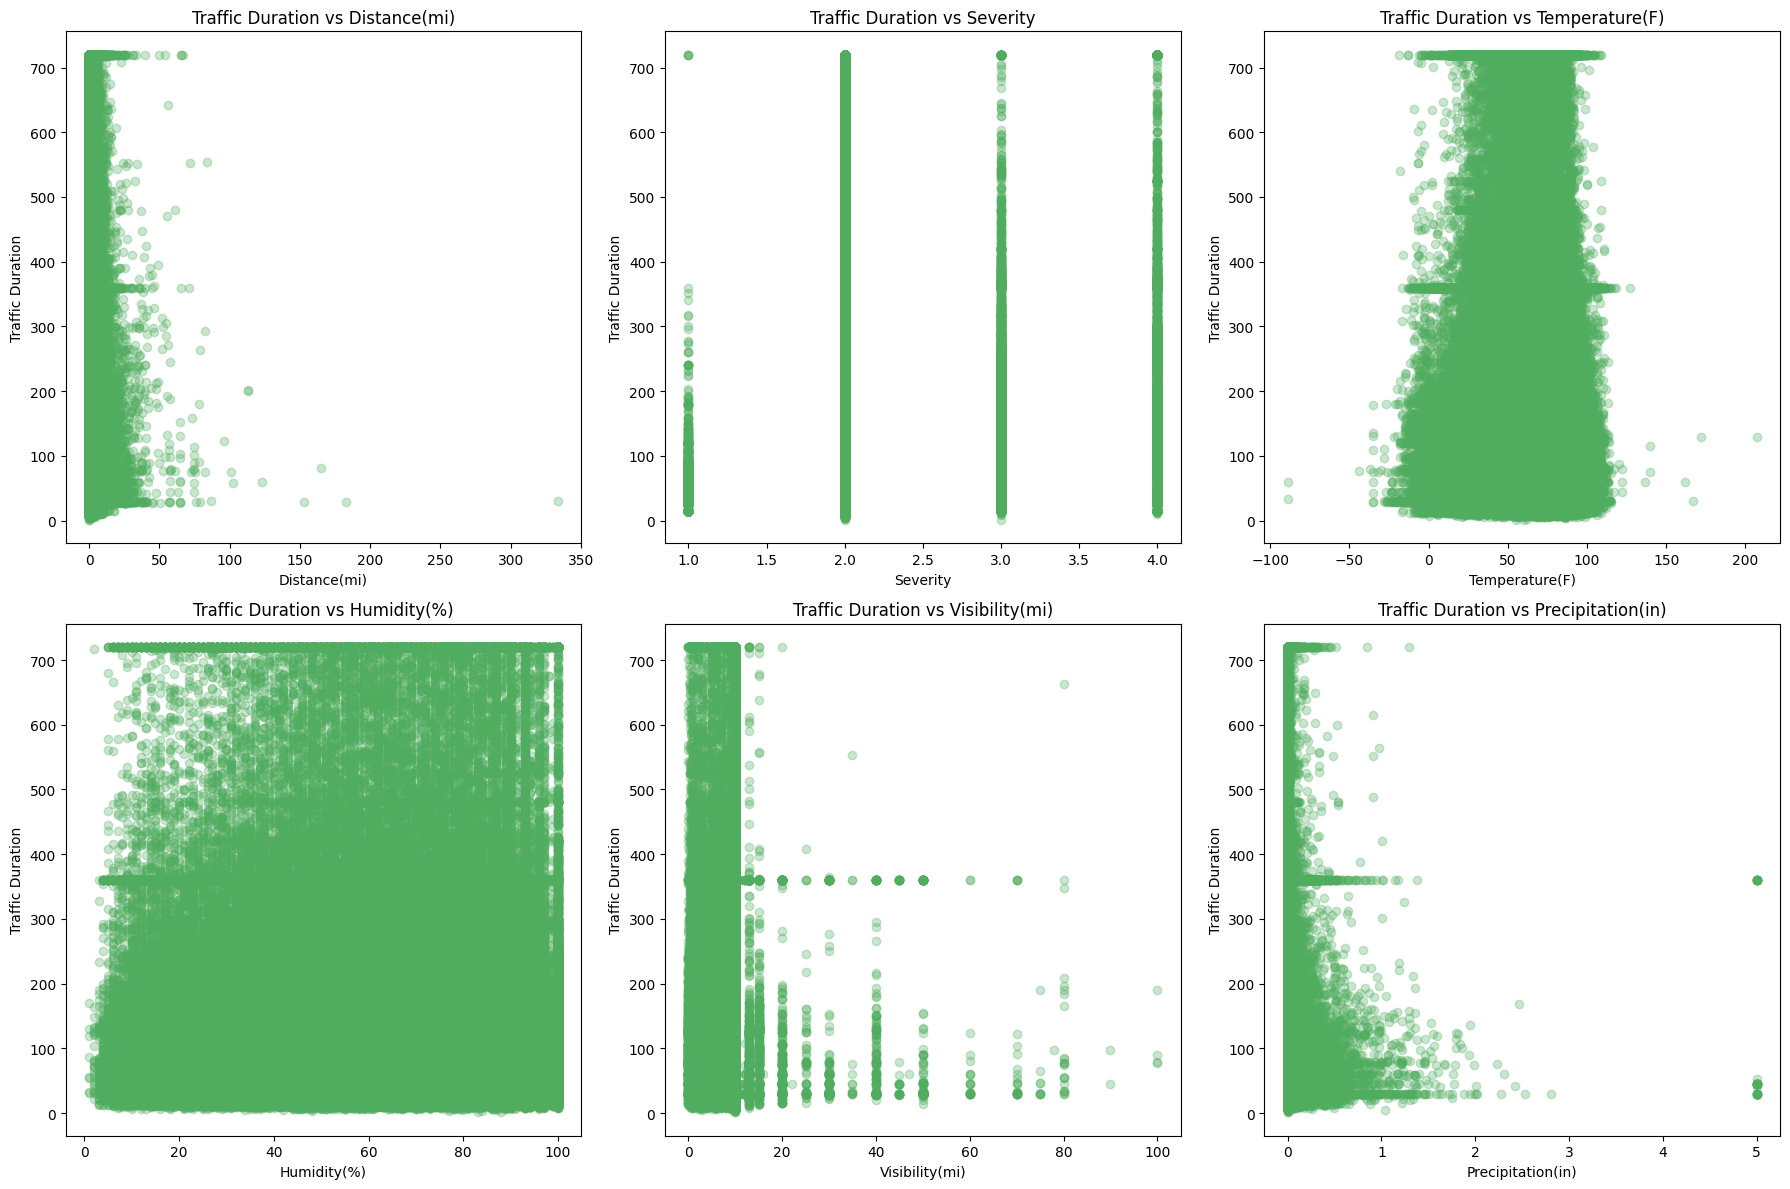

In [ ]:
# Scatter PLot
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()


for i, col in enumerate(columns_to_plot):
    axes[i].scatter(df_pandas[col], df_pandas['Traffic_Duration'], alpha=0.3, color="#50ad5f")
    axes[i].set_title(f'Traffic Duration vs {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Traffic Duration')

plt.tight_layout()
plt.show()


In [ ]:
# # Variables correlation
# for col in columns_to_plot:
#     correlation = data.stat.corr('Traffic_Duration', col)
#     print(f"Correlation between Traffic_Duration and {col}: {correlation}")

### Log Traffic duration, normal regressor

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

df_pandas = data.select(columns_to_plot + ['Log_Traffic_Duration']).sample(fraction = 0.08).toPandas()

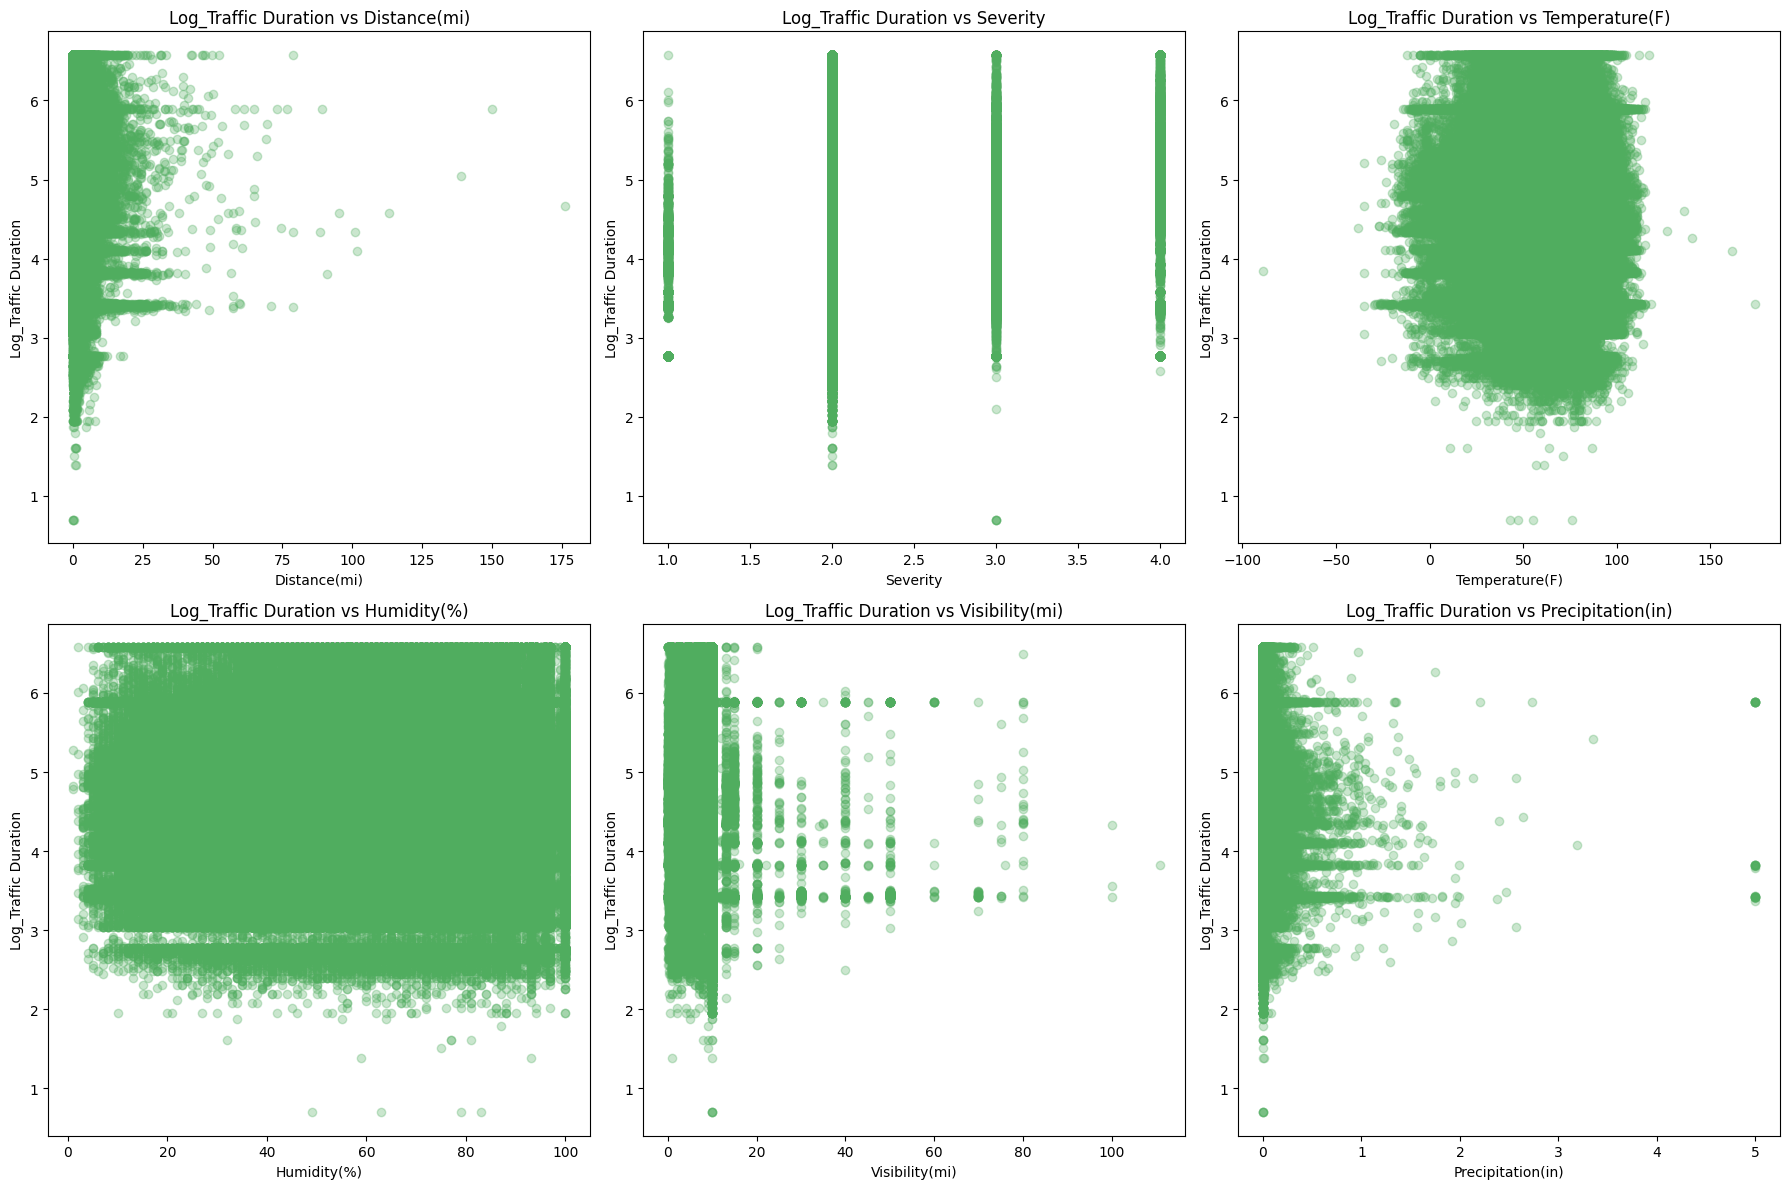

In [ ]:
# Creazione di scatter plot
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for i, col in enumerate(columns_to_plot):
    axes[i].scatter(df_pandas[col], df_pandas['Log_Traffic_Duration'], alpha=0.3, color="#50ad5f")
    axes[i].set_title(f'Log_Traffic Duration vs {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Log_Traffic Duration')

plt.tight_layout()
plt.show()


In [ ]:
for col in columns_to_plot:
    correlation = data.stat.corr('Log_Traffic_Duration', col)
    print(f"Correlation between Traffic_Duration and {col}: {correlation}")

Correlation between Traffic_Duration and Distance(mi): 0.15012383807836197
Correlation between Traffic_Duration and Distance(mi): 0.15012383807836197


Correlation between Traffic_Duration and Severity: -0.05033893463163349
Correlation between Traffic_Duration and Severity: -0.05033893463163349


Correlation between Traffic_Duration and Temperature(F): -0.011628947505548772
Correlation between Traffic_Duration and Temperature(F): -0.011628947505548772


Correlation between Traffic_Duration and Humidity(%): -0.013679851797489566
Correlation between Traffic_Duration and Humidity(%): -0.013679851797489566


Correlation between Traffic_Duration and Visibility(mi): 0.00698262875043876
Correlation between Traffic_Duration and Visibility(mi): 0.00698262875043876


Correlation between Traffic_Duration and Precipitation(in): -0.0055848244656492565
Correlation between Traffic_Duration and Precipitation(in): -0.0055848244656492565


## Multiple Linear Regression

### Using only weather condition

In [ ]:
df_simple_regression = data.select('Traffic_Duration', 'Weather_Condition')

In [ ]:
categories = [row["Weather_Condition"] for row in df_simple_regression.select("Weather_Condition").distinct().collect()]

In [ ]:
# One Hot Encoding
for category in categories:
    df_simple_regression = df_simple_regression.withColumn(category, when(col("Weather_Condition") == category, 1).otherwise(0))
df_simple_regression = df_simple_regression.drop("Weather_Condition")

In [ ]:
df_simple_regression.show()

+-----------------+------------+-----------------+-----------------------+------+----------+-----+---------------+-------+-------------+-------+-------+---+-----+----+-----+------------+----+-------+----+----+----+-----------------------+----+--------+-----------------+-----------+-------+----------+----+
| Traffic_Duration|Thunderstorm|N/A Precipitation|Showers in the Vicinity|Cloudy|Wintry Mix|Sleet|Widespread Dust|Squalls|Heavy T-Storm|Drizzle|T-Storm|Fog|Clear|Fair|Smoke|Blowing Dust|Sand|Thunder|Mist|Snow|Rain|Thunder in the Vicinity|Haze|Overcast|Light Ice Pellets|Ice Pellets|Tornado|Small Hail|Hail|
+-----------------+------------+-----------------+-----------------------+------+----------+-----+---------------+-------+-------------+-------+-------+---+-----+----+-----+------------+----+-------+----+----+----+-----------------------+----+--------+-----------------+-----------+-------+----------+----+
|             30.0|           0|                0|                      0|     

In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression

feature_columns = [col for col in df_simple_regression.columns if col != "Traffic_Duration"]
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

lr = LinearRegression(featuresCol="features", labelCol="Traffic_Duration", predictionCol="prediction")

pipeline = Pipeline(stages=[assembler, lr])

# data split
train_data, test_data = df_simple_regression.randomSplit([0.8, 0.2], seed=42)

### Training

In [ ]:
# train the model
pipeline_model = pipeline.fit(train_data)

In [ ]:
training_summary = lr_model.summary

print("\nCoefficients:")
for i, (coef) in zip(
    categories,
    lr_model.coefficients
):
    print(f"Coefficient {i}:")
    print(f"   Value: {coef}")


Coefficients:  [-12.881623631662885,29.965145179872525,-13.114250700146105,1.0910622947440325,16.358531519225068,3.098196664005795,-46.78747283090921,-43.75831608192816,3.3050878904498773,-7.231501215946556,-8.311050985920886,1.202120459015088,-14.377659732671939,8.721768150947009,15.806582601808062,3.755813536501503,-63.158252184512875,-3.6316675666657785,-11.059082581417655,8.267033500713833,-4.7880434977219535,3.0062740143254585,-2.241289458731821,-14.634618566037327,-46.8846950665979,-70.63322765840059,16.141486942728363,0.0,-57.85826961989272]
Intercept:  107.85845715571364

Significance of Coefficients:
Coefficient N/A Precipitation:
   Value: -12.881623631662885
Coefficient Cloudy:
   Value: 29.965145179872525
Coefficient Wintry Mix:
   Value: -13.114250700146105
Coefficient Sleet:
   Value: 1.0910622947440325
Coefficient Widespread Dust:
   Value: 16.358531519225068
Coefficient Squalls:
   Value: 3.098196664005795
Coefficient Heavy T-Storm:
   Value: -46.78747283090921
Coeffici

In [ ]:
# Print evaluation metrics
print("Coefficients: ", lr_model.coefficients)
print("Intercept: ", lr_model.intercept)
print("RMSE: ", test_results.rootMeanSquaredError)
print("R2: ", test_results.r2)

Coefficients:  [-12.881623631662885,29.965145179872525,-13.114250700146105,1.0910622947440325,16.358531519225068,3.098196664005795,-46.78747283090921,-43.75831608192816,3.3050878904498773,-7.231501215946556,-8.311050985920886,1.202120459015088,-14.377659732671939,8.721768150947009,15.806582601808062,3.755813536501503,-63.158252184512875,-3.6316675666657785,-11.059082581417655,8.267033500713833,-4.7880434977219535,3.0062740143254585,-2.241289458731821,-14.634618566037327,-46.8846950665979,-70.63322765840059,16.141486942728363,0.0,-57.85826961989272]
Intercept:  107.85845715571364
RMSE:  121.15887398785578
R2:  0.003645887546552262
Coefficients:  [-12.881623631662885,29.965145179872525,-13.114250700146105,1.0910622947440325,16.358531519225068,3.098196664005795,-46.78747283090921,-43.75831608192816,3.3050878904498773,-7.231501215946556,-8.311050985920886,1.202120459015088,-14.377659732671939,8.721768150947009,15.806582601808062,3.755813536501503,-63.158252184512875,-3.6316675666657785,-11

The simple regression using only weather conditions is not informative

### Using only weather condition but with Log_Duration

In [ ]:
from pyspark.sql.functions import col, when

df_simple_regression = data.select('Log_Traffic_Duration', 'Weather_Condition')

categories = [row["Weather_Condition"] for row in df_simple_regression.select("Weather_Condition").distinct().collect()]

# OHE
for category in categories:
    df_simple_regression = df_simple_regression.withColumn(category, when(col("Weather_Condition") == category, 1).otherwise(0))
df_simple_regression = df_simple_regression.drop("Weather_Condition")

In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression

feature_columns = [col for col in df_simple_regression.columns if col != "Log_Traffic_Duration"]
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

lr = LinearRegression(featuresCol="features", labelCol="Log_Traffic_Duration", predictionCol="prediction")

pipeline = Pipeline(stages=[assembler, lr])

# data split
train_data, test_data = df_simple_regression.randomSplit([0.8, 0.2], seed=42)

In [ ]:
# train the model
pipeline_model = pipeline.fit(train_data)

In [ ]:
test_data_transformed = pipeline_model.transform(test_data)

test_data_transformed = test_data_transformed.drop("prediction")

lr_model = pipeline_model.stages[-1]  # The last stage is the Linear Regression model

# Evaluate the model
test_results = lr_model.evaluate(test_data_transformed)

# metrics
print("Coefficients: ", lr_model.coefficients)
print("Intercept: ", lr_model.intercept)
print("RMSE: ", test_results.rootMeanSquaredError)
print("R2: ", test_results.r2)

Coefficients:  [-467.50213381730975,-467.7551828077997,-467.47843750691027,-467.5720743054887,-468.0816827641996,-468.17229579673057,-467.66286020226994,-467.8279425914615,-467.7315926747726,-467.6883364306375,-468.0554217270625,-467.62259681530264,-467.6674434595986,-467.6871255996509,-468.2492725237039,-467.7016952285151,-467.92875140545897,-467.6612866993679,-467.8009757996542,-467.80389719571104,-468.0644042835849,-468.3654139596033,-467.2430570843018,-468.1395451888798]
Intercept:  472.07137082160415
RMSE:  0.8113105569935629
R2:  0.03020566446331141
Coefficients:  [-467.50213381730975,-467.7551828077997,-467.47843750691027,-467.5720743054887,-468.0816827641996,-468.17229579673057,-467.66286020226994,-467.8279425914615,-467.7315926747726,-467.6883364306375,-468.0554217270625,-467.62259681530264,-467.6674434595986,-467.6871255996509,-468.2492725237039,-467.7016952285151,-467.92875140545897,-467.6612866993679,-467.8009757996542,-467.80389719571104,-468.0644042835849,-468.36541395960

The metric are slightly better than before but still not informative

In [ ]:
training_summary = lr_model.summary

print("\nSignificance of Coefficients:")
for i, (coef) in zip(
    categories,
    lr_model.coefficients
):
    print(f"Coefficient {i}:")
    print(f"   Value: {coef}")



Significance of Coefficients:
Coefficient N/A Precipitation:
   Value: -467.50213381730975
Coefficient Cloudy:
   Value: -467.7551828077997
Coefficient Wintry Mix:
   Value: -467.47843750691027
Coefficient Sleet:
   Value: -467.5720743054887
Coefficient Widespread Dust:
   Value: -468.0816827641996
Coefficient Squalls:
   Value: -468.17229579673057
Coefficient Heavy T-Storm:
   Value: -467.66286020226994
Coefficient Drizzle:
   Value: -467.8279425914615
Coefficient T-Storm:
   Value: -467.7315926747726
Coefficient Fog:
   Value: -467.6883364306375
Coefficient Clear:
   Value: -468.0554217270625
Coefficient Fair:
   Value: -467.62259681530264
Coefficient Smoke:
   Value: -467.6674434595986
Coefficient Blowing Dust:
   Value: -467.6871255996509
Coefficient Sand:
   Value: -468.2492725237039
Coefficient Thunder:
   Value: -467.7016952285151
Coefficient Mist:
   Value: -467.92875140545897
Coefficient Snow:
   Value: -467.6612866993679
Coefficient Rain:
   Value: -467.8009757996542
Coeffic

## Multiple Regression

we try to run the regression first with binary and numerical variables

In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.sql.types import NumericType

numerical_columns = [
    'Temperature(F)', 'Humidity(%)', 'Pressure(in)','Precipitation(in)', 'Log_Distance', 'Log_Wind_Speed', 'Severity',
    'Crossing', 'Junction', 'Station', 'Traffic_Signal', 'Civil_Twilight', 'Weekend_day'
]

assembler = VectorAssembler(inputCols=numerical_columns, outputCol="features")
data_transformed = assembler.transform(data)

# data split
train_data, test_data = data_transformed.randomSplit([0.8, 0.2], seed=42)

# define model
lr = LinearRegression(featuresCol="features", labelCol="Log_Traffic_Duration", predictionCol="prediction")

lr_model = lr.fit(train_data)

# evaluate
test_results = lr_model.evaluate(test_data)


print("Coefficients: ", lr_model.coefficients)
print("Intercept: ", lr_model.intercept)
print("RMSE: ", test_results.rootMeanSquaredError)
print("R2: ", test_results.r2)
print("MAE: ", test_results.meanAbsoluteError)

Numerical Columns: ['Temperature(F)', 'Humidity(%)', 'Pressure(in)', 'Precipitation(in)', 'Log_Distance', 'Log_Wind_Speed', 'Severity', 'Crossing', 'Junction', 'Station', 'Traffic_Signal', 'Civil_Twilight', 'Weekend_day']
Numerical Columns: ['Temperature(F)', 'Humidity(%)', 'Pressure(in)', 'Precipitation(in)', 'Log_Distance', 'Log_Wind_Speed', 'Severity', 'Crossing', 'Junction', 'Station', 'Traffic_Signal', 'Civil_Twilight', 'Weekend_day']


Coefficients:  [0.0004658845196475888,-0.0010458537792915365,-0.027067853236034983,0.016515846408546066,0.4417659386256919,-0.030523244639315966,-0.1370214682888246,0.05586068793430805,0.061075957740668305,0.11734906179357187,-0.17248662288374195,-0.12196650274229318,0.08054368613698844]
Intercept:  5.484642760124979
RMSE:  0.7913737736839952
R2:  0.08710657665441512
MAE:  0.6207235740547081
Coefficients:  [0.0004658845196475888,-0.0010458537792915365,-0.027067853236034983,0.016515846408546066,0.4417659386256919,-0.030523244639315966,-0.1370214682888246,0.05586068793430805,0.061075957740668305,0.11734906179357187,-0.17248662288374195,-0.12196650274229318,0.08054368613698844]
Intercept:  5.484642760124979
RMSE:  0.7913737736839952
R2:  0.08710657665441512
MAE:  0.6207235740547081


The R^2 is better but still not informative

In [ ]:
training_summary = lr_model.summary

# Coefficients and their significance
print("\nCoefficients:")
for i, (coef, col) in enumerate(zip(lr_model.coefficients, numerical_columns)):
    print(f"Feature: {col}")
    print(f"   Coefficient: {coef}")
    print(f"   StdErr: {training_summary.coefficientStandardErrors[i]}")
    print(f"   T-value: {training_summary.tValues[i]}")
    print(f"   P-value: {training_summary.pValues[i]}")

print("Intercept: ", lr_model.intercept)


Coefficients:
Feature: Temperature(F)
   Coefficient: 0.0004658845196475888
   StdErr: 0.000185834603960086
   T-value: 2.5069847580575066
   P-value: 0.012179206921465013
Feature: Humidity(%)
   Coefficient: -0.0010458537792915365
   StdErr: 0.00015576323788658305
   T-value: -6.714381348781804
   P-value: 1.905342550401201e-11
Feature: Pressure(in)
   Coefficient: -0.027067853236034983
   StdErr: 0.003259408722617248
   T-value: -8.304528685896125
   P-value: 0.0
Feature: Precipitation(in)
   Coefficient: 0.016515846408546066
   StdErr: 0.07302624277543966
   T-value: 0.2261631679358521
   P-value: 0.8210752833446957
Feature: Log_Distance
   Coefficient: 0.4417659386256919
   StdErr: 0.007064727594578469
   T-value: 62.53120629374398
   P-value: 0.0
Feature: Log_Wind_Speed
   Coefficient: -0.030523244639315966
   StdErr: 0.004100401448358879
   T-value: -7.443964944342807
   P-value: 9.903189379656396e-14
Feature: Severity
   Coefficient: -0.1370214682888246
   StdErr: 0.00665786857

   P-value: 8.595941567435261e-07
Feature: Station
   Coefficient: 0.11734906179357187
   StdErr: 0.020649427270385406
   T-value: 5.68292089930597
   P-value: 1.330228172058412e-08
Feature: Traffic_Signal
   Coefficient: -0.17248662288374195
   StdErr: 0.010388002982206322
   T-value: -16.604406369462485
   P-value: 0.0
Feature: Civil_Twilight
   Coefficient: -0.12196650274229318
   StdErr: 0.007847211651893367
   T-value: -15.542654913973834
   P-value: 0.0
Feature: Weekend_day
   Coefficient: 0.08054368613698844
   StdErr: 0.008898556291102809
   T-value: 9.051320630237488
   P-value: 0.0
Intercept:  5.484642760124979
   P-value: 8.595941567435261e-07
Feature: Station
   Coefficient: 0.11734906179357187
   StdErr: 0.020649427270385406
   T-value: 5.68292089930597
   P-value: 1.330228172058412e-08
Feature: Traffic_Signal
   Coefficient: -0.17248662288374195
   StdErr: 0.010388002982206322
   T-value: -16.604406369462485
   P-value: 0.0
Feature: Civil_Twilight
   Coefficient: -0.12196

### Model adding categorical one hot encoded variables

In [747]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml import Pipeline


categorical_columns = ["Hour", "Month", "Weather_Condition","Severity","Day_of_Week"]

indexers = [
    StringIndexer(inputCol=col, outputCol=f"{col}_indexed", handleInvalid="skip")
    for col in categorical_columns
]

encoders = [
    OneHotEncoder(inputCol=f"{col}_indexed", outputCol=f"{col}_encoded")
    for col in categorical_columns
]

numerical_columns = [
    field.name for field in data.schema.fields
    if isinstance(field.dataType, NumericType) and field.name not in [
        "Hour", "Month","Severity","Day_of_Week","Traffic_Duration", "Log_Traffic_Duration", 'Wind_Speed(mph)',
        'Precipitation(mi)', 'Distance(mi)', 'Visibility(mi)', 'Year','Start_Lat', 'Start_Lng','Day_of_Year'
        ]
]

feature_columns = numerical_columns + [f"{col}_encoded" for col in categorical_columns]

assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

# model
lr = LinearRegression(featuresCol="features", labelCol="Log_Traffic_Duration", predictionCol="prediction")

pipeline = Pipeline(stages=indexers + encoders + [assembler, lr])

# data split
train_data, test_data = data.randomSplit([0.8, 0.2], seed=42)

pipeline_model = pipeline.fit(train_data)

test_data_transformed = pipeline_model.transform(test_data)
test_data_transformed = test_data_transformed.drop("prediction")

# evaluate
test_results = pipeline_model.stages[-1].evaluate(test_data_transformed)

#results
lr_model = pipeline_model.stages[-1]  # Extract the linear regression model
print("Coefficients: ", lr_model.coefficients)
print("Intercept: ", lr_model.intercept)
print("RMSE: ", test_results.rootMeanSquaredError)
print("R2: ", test_results.r2)
print("MAE: ", test_results.meanAbsoluteError)


Coefficients:  [0.0016237460656048379,0.0005557377368984081,-0.015603004313093527,-0.006498740579725965,-0.01626958524540512,-0.02024076998815783,0.020783993988693975,-0.01225003818064096,0.07967520036906292,0.09654318463754193,0.02678445324384105,0.6256117935755706,0.09764444207056057,-0.04152438281583715,0.07300779385317616,-0.1679552995920205,-0.030634068526761534,-0.009680182844027675,0.05678186925798546,0.3495937330773202,0.029814505478560505,0.03893278958396958,-0.2881709346589538,-0.21875922548846877,-0.19693225494420258,-0.29741227108534085,-0.1582014550538934,-0.0899716435212069,-0.2342966170852766,-0.17043081923241468,-0.08504456352255751,-0.19620017405465487,-0.23895321074790846,-0.1035373540405485,-0.21614928432082148,-0.211929732130277,-0.09089999748144029,-0.17533281018463,-0.1574336125285301,-0.14636398910256354,-0.17004908903712512,-0.07898445036216149,-0.0250688494057794,-0.0030723377825411075,-0.004634643297113999,0.082948271588252,0.09055905911809504,0.03757411064188

In [751]:
training_summary = lr_model.summary

categorical_feature_names = []

for col in categorical_columns:
    # Find the StringIndexerModel corresponding to the current column
    indexer_model = next(
        stage for stage in pipeline_model.stages 
        if stage.__class__.__name__ == "StringIndexerModel" and stage.getInputCol() == col
    )
    
    # Retrieve the categories from the StringIndexerModel
    categories = indexer_model.labels

    # Adjust for one-hot encoding
    categorical_feature_names.extend([f"{col}_{category}" for category in categories[:-1]])  # Exclude the reference category

all_feature_names = numerical_columns + categorical_feature_names

# Validate feature name count matches coefficients
if len(all_feature_names) != len(lr_model.coefficients):
    print(f"Feature name count ({len(all_feature_names)}) does not match coefficient count ({len(lr_model.coefficients)})!")
else:
    print("Feature name count matches coefficient count.")

print("\nCoefficients and Features:")
for name, coef in zip(all_feature_names, lr_model.coefficients):
    print(f"Feature: {name}, Coefficient: {coef}")


Feature name count matches coefficient count.

Coefficients and Features:
Feature: Temperature(F), Coefficient: 0.0016237460656048379
Feature: Humidity(%), Coefficient: 0.0005557377368984081
Feature: Pressure(in), Coefficient: -0.015603004313093527
Feature: Precipitation(in), Coefficient: -0.006498740579725965
Feature: Amenity, Coefficient: -0.01626958524540512
Feature: Bump, Coefficient: -0.02024076998815783
Feature: Crossing, Coefficient: 0.020783993988693975
Feature: Give_Way, Coefficient: -0.01225003818064096
Feature: Junction, Coefficient: 0.07967520036906292
Feature: No_Exit, Coefficient: 0.09654318463754193
Feature: Railway, Coefficient: 0.02678445324384105
Feature: Roundabout, Coefficient: 0.6256117935755706
Feature: Station, Coefficient: 0.09764444207056057
Feature: Stop, Coefficient: -0.04152438281583715
Feature: Traffic_Calming, Coefficient: 0.07300779385317616
Feature: Traffic_Signal, Coefficient: -0.1679552995920205
Feature: Civil_Twilight, Coefficient: -0.0306340685267615

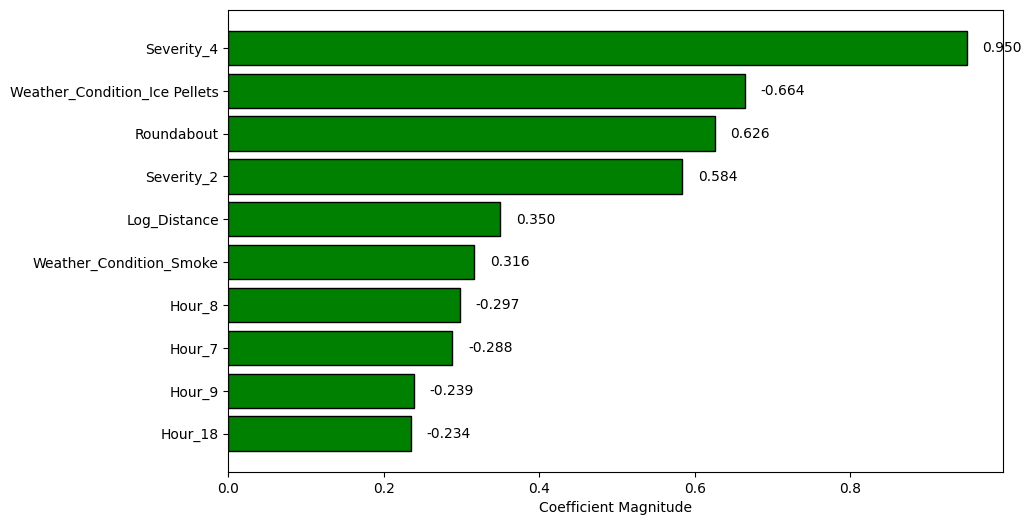

In [753]:
import matplotlib.pyplot as plt

coef_data = pd.DataFrame({
    "Feature": all_feature_names,
    "Coefficient": lr_model.coefficients.toArray()
})

coef_data["Abs_Coefficient"] = coef_data["Coefficient"].abs()
coef_data = coef_data.sort_values(by="Abs_Coefficient", ascending=False)
coef_data = coef_data.head(10)

# feature importance
plt.figure(figsize=(10, 6))
bars = plt.barh(coef_data["Feature"], coef_data["Abs_Coefficient"], color="green", edgecolor="black")

# Add text annotations for each bar
for bar, coef in zip(bars, coef_data["Coefficient"]):
    plt.text(
        bar.get_width() + 0.02, 
        bar.get_y() + bar.get_height() / 2,
        f"{coef:.3f}",  
        va='center', 
        fontsize=10 
    )

plt.xlabel("Coefficient Magnitude")
plt.gca().invert_yaxis()
plt.show()


### Plotting residuals

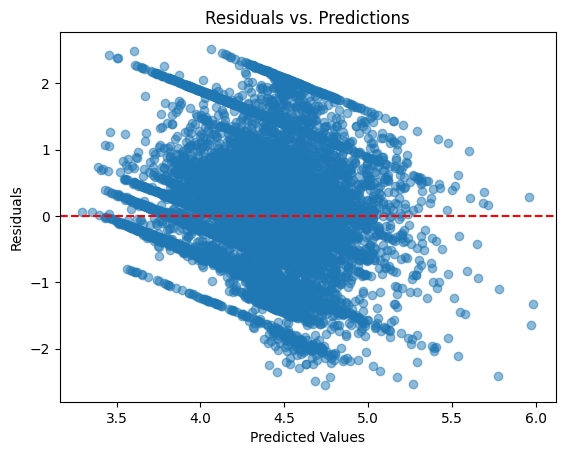

In [ ]:
import matplotlib.pyplot as plt

test_data_transformed = pipeline_model.transform(test_data)

residuals = test_results.residuals.toPandas()
predictions = test_data_transformed.select("prediction").toPandas()

plot_data = residuals.join(predictions)

# Plot
plt.scatter(plot_data["prediction"], plot_data["residuals"], alpha=0.5)
plt.axhline(y=0, color="r", linestyle="--")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs. Predictions")
plt.show()


### Residuals distribution

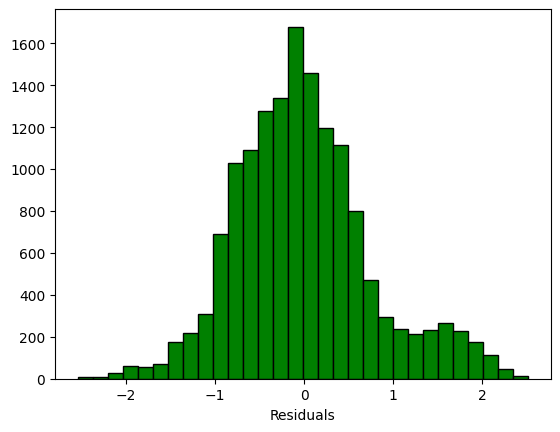

In [ ]:
residuals = test_results.residuals.toPandas()

# Plot
plt.hist(residuals["residuals"], bins=30, color="green", edgecolor="black")
plt.xlabel("Residuals")
plt.show()


# CLUSTERING

## kmeans

### Identifying best k: elbow method

Model with all standardized featured

In [ ]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.feature import VectorAssembler, StandardScaler

# Identify numeric columns and exclude specific ones
excluded_columns = {'Log_Visibility', 'Log_Distance', 'Log_Traffic_Duration', 'Log_Precipitation', 'Log_Wind_Speed'}
numeric_columns = [
    field.name for field in data.schema.fields 
    if str(field.dataType) in ['IntegerType()', 'DoubleType()'] and field.name not in excluded_columns
]

assembler = VectorAssembler(inputCols=numeric_columns, outputCol="raw_features")
vectorized_data = assembler.transform(data)

# Standardization
scaler = StandardScaler(inputCol="raw_features", outputCol="features", withStd=True, withMean=True)
scaler_model = scaler.fit(vectorized_data)
standardized_data = scaler_model.transform(vectorized_data)

# elbow
k_values = range(4, 10)  # Test k from 2 to 10
costs = []

for k in k_values:
    kmeans = KMeans(k=k, seed=1, featuresCol="features", maxIter=20)
    model = kmeans.fit(standardized_data)
    # WSSE
    cost = model.summary.trainingCost
    costs.append(cost)
    print(f"Cost for k={k}: {cost}")


Cost for k=4: 1984988.412520126
Cost for k=4: 1984988.412520126


Cost for k=5: 1944228.3795925637
Cost for k=5: 1944228.3795925637


Cost for k=6: 1837126.4552556458
Cost for k=6: 1837126.4552556458


Cost for k=7: 1724131.3364264297
Cost for k=7: 1724131.3364264297


Cost for k=8: 1732207.5320177535
Cost for k=8: 1732207.5320177535


Cost for k=9: 1732626.4701303688
Cost for k=9: 1732626.4701303688


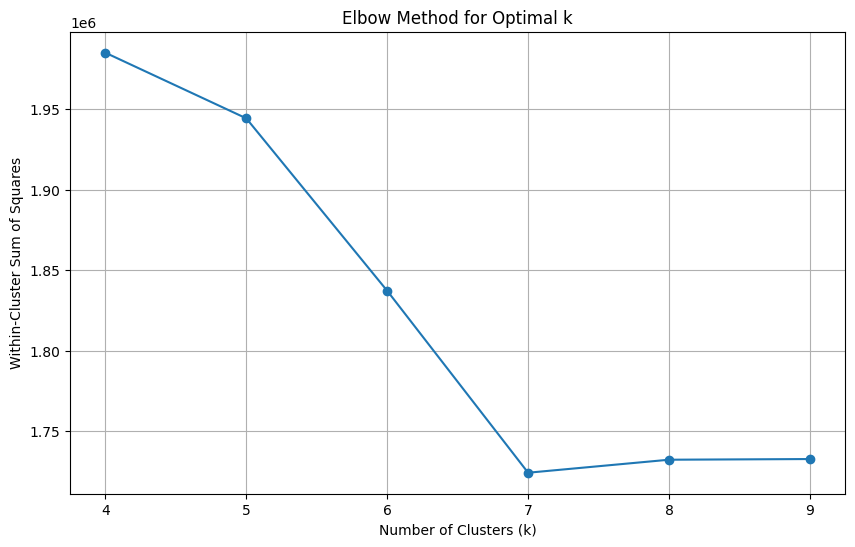

In [ ]:
import matplotlib.pyplot as plt

# elbow curve
plt.figure(figsize=(10, 6))
plt.plot(k_values, costs, marker='o')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Within-Cluster Sum of Squares")
plt.title("Elbow Method for Optimal k")
plt.xticks(k_values)
plt.grid()
plt.show()

Model with some variables and not all standardized

In [ ]:
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

excluded_columns = {'Visibility(mi)', 'Distance(mi)', 'Traffic_Duration', 'Precipitation(in)','Wind_Speed(mph)',
'Day_of_Year','Year','Day_of_Week','Start_Lat', 'Start_Lng', 'Hour', 'Month'}
numeric_columns = [
    field.name for field in data.schema.fields 
    if str(field.dataType) in ['IntegerType()', 'DoubleType()'] and field.name not in excluded_columns
]

# Specify columns to scale and columns to keep unscaled
columns_to_scale = ['Log_Visibility', 'Log_Distance', 'Log_Traffic_Duration', 'Log_Precipitation', 'Log_Wind_Speed',
'Temperature(F)', 'Humidity(%)', 'Pressure(in)', 'Severity']
columns_to_keep_unscaled = [col for col in numeric_columns if col not in columns_to_scale]

# vectorize features to scale
assembler_to_scale = VectorAssembler(inputCols=columns_to_scale, outputCol="raw_scaled_features")
scaled_data = assembler_to_scale.transform(data)

# standardization
scaler = StandardScaler(inputCol="raw_scaled_features", outputCol="scaled_features", withStd=True, withMean=True)
scaler_model = scaler.fit(scaled_data)
scaled_features_data = scaler_model.transform(scaled_data)

# vectorize unscaled features
assembler_unscaled = VectorAssembler(inputCols=columns_to_keep_unscaled, outputCol="unscaled_features")
unscaled_features_data = assembler_unscaled.transform(scaled_features_data)

# Step 5: Combine scaled and unscaled features
final_assembler = VectorAssembler(inputCols=["scaled_features", "unscaled_features"], outputCol="features")
final_data = final_assembler.transform(unscaled_features_data)


In [ ]:
k_values = range(4, 15)  # Test k from 4 to 9
costs = []

for k in k_values:
    kmeans = KMeans(k=k, seed=1, featuresCol="features", maxIter=20)
    model = kmeans.fit(final_data)
    # WSSE
    cost = model.summary.trainingCost
    costs.append(cost)
    print(f"Cost for k={k}: {cost}")

Cost for k=4: 537954.5957382137
Cost for k=4: 537954.5957382137


Cost for k=5: 501131.35147205624
Cost for k=5: 501131.35147205624


Cost for k=6: 456662.40290165937
Cost for k=6: 456662.40290165937


Cost for k=7: 413859.38403937576
Cost for k=7: 413859.38403937576


Cost for k=8: 408744.78471519676
Cost for k=8: 408744.78471519676


Cost for k=9: 370219.63876934716
Cost for k=9: 370219.63876934716


Cost for k=10: 351415.90275754983
Cost for k=10: 351415.90275754983


Cost for k=11: 338610.2535382537
Cost for k=11: 338610.2535382537


Cost for k=12: 335650.8987408511
Cost for k=12: 335650.8987408511


Cost for k=13: 322303.9581551083
Cost for k=13: 322303.9581551083


Cost for k=14: 310864.43633224396
Cost for k=14: 310864.43633224396


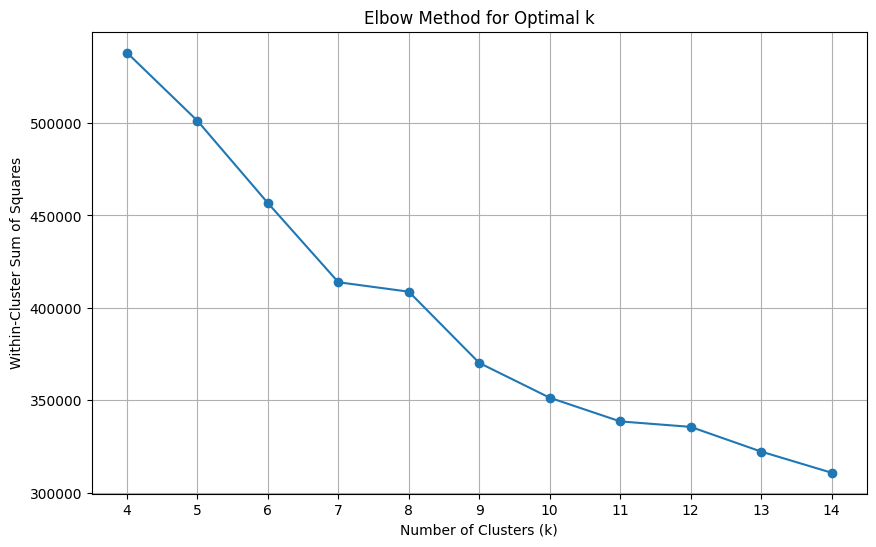

In [ ]:
import matplotlib.pyplot as plt
# elbow curve
plt.figure(figsize=(10, 6))
plt.plot(k_values, costs, marker='o')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Within-Cluster Sum of Squares")
plt.title("Elbow Method for Optimal k")
plt.xticks(k_values)
plt.grid()
plt.show()

### Running kmeans

best k option could be:

- k = 7
- k = 11

we choose the 2nd set of variable because they're more informative about the accident, furthermore it uses the log-transformed features that are better distributed and doesn't consider time variable (Month, Day_of_Week,...) for which euclidean distance is not so informative (distance between 1 and 7 is 7-1=6, but in reality the day-distance between Sunday and Saturday is 1)

We then choose 11 of k

In [ ]:
# train the model
kmeans = KMeans(k=11, seed=1, featuresCol="features", maxIter=20)
model = kmeans.fit(final_data)

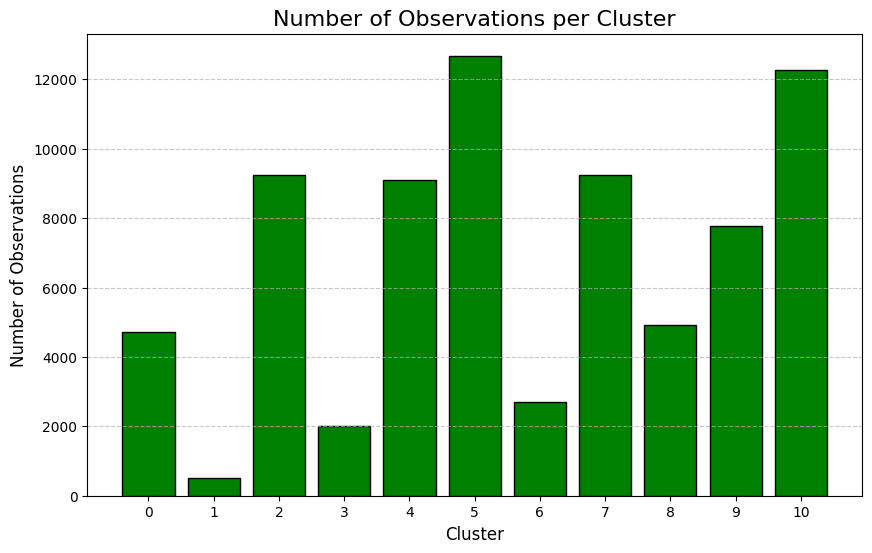

In [ ]:
from pyspark.sql import functions as F
import matplotlib.pyplot as plt

clustered_data = model.transform(final_data)

cluster_counts = clustered_data.groupBy("prediction").agg(F.count("*").alias("count"))

# pandas for visualization
cluster_counts_pd = cluster_counts.toPandas()

# bar chart
plt.figure(figsize=(10, 6))
plt.bar(cluster_counts_pd["prediction"], cluster_counts_pd["count"], color="green", edgecolor="black")
plt.title("Number of Observations per Cluster", fontsize=16)
plt.xlabel("Cluster", fontsize=12)
plt.ylabel("Number of Observations", fontsize=12)
plt.xticks(cluster_counts_pd["prediction"], fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


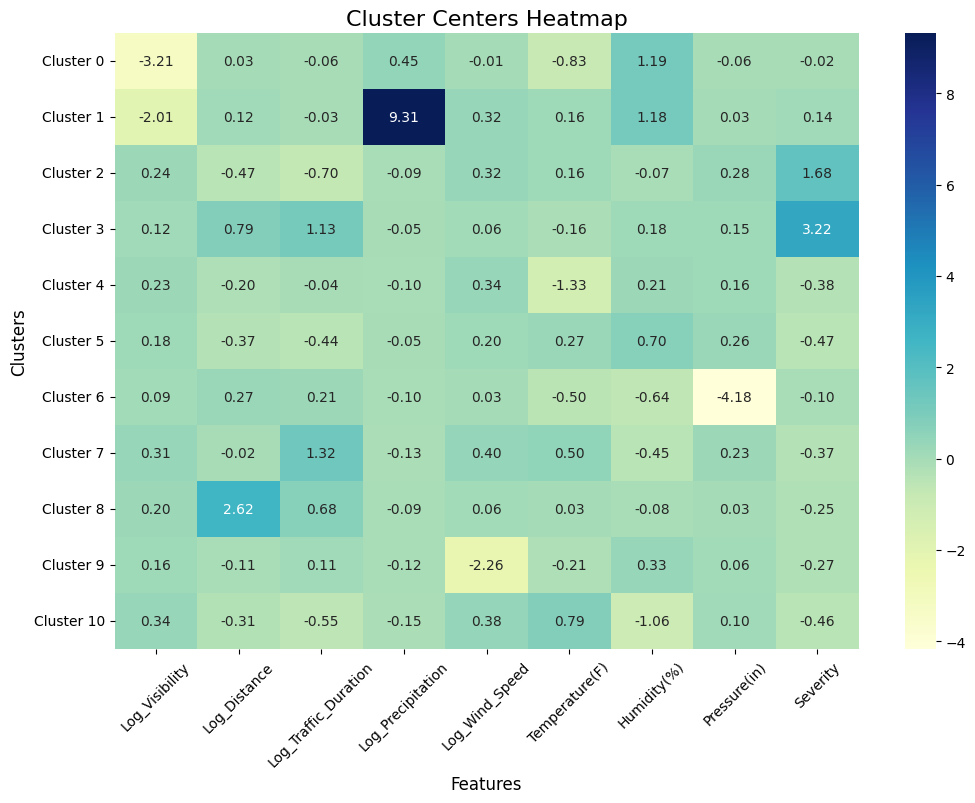

In [ ]:
all_feature_names = columns_to_scale + columns_to_keep_unscaled

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

cluster_centers = model.clusterCenters()
cluster_centers_df = pd.DataFrame(cluster_centers, columns=all_feature_names)

selected_feature_names = all_feature_names[:9]
cluster_centers_df_subset = cluster_centers_df[selected_feature_names]

# heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(cluster_centers_df_subset, cmap="YlGnBu", annot=True, fmt=".2f", 
            xticklabels=selected_feature_names, yticklabels=[f"Cluster {i}" for i in range(len(cluster_centers))])
plt.title("Cluster Centers Heatmap", fontsize=16)
plt.xlabel("Features", fontsize=12)
plt.ylabel("Clusters", fontsize=12)
plt.xticks(rotation=45)
plt.show()



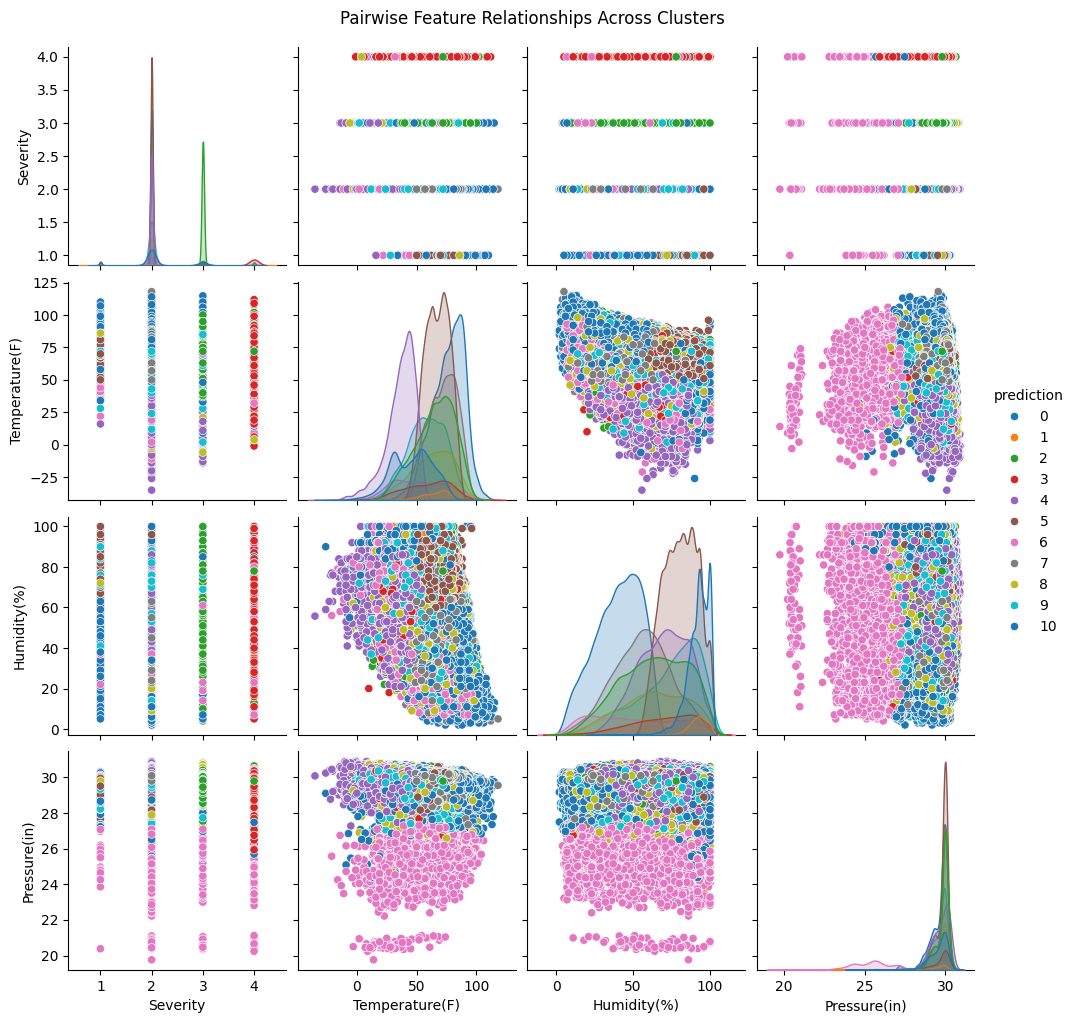

In [ ]:
import seaborn as sns

clustered_pd = clustered_data.toPandas()

pairplot_features = numeric_columns[:4]  # Select a subset of features for clarity
clustered_pd_subset = clustered_pd[pairplot_features + ["prediction"]]

# Pairplot
sns.pairplot(clustered_pd_subset, hue="prediction", diag_kind="kde", palette="tab10")
plt.suptitle("Pairwise Feature Relationships Across Clusters", y=1.02)
plt.show()

In [ ]:
cluster_3_data = clustered_data.filter(clustered_data.prediction == 3)

In [ ]:
summary_stats = cluster_3_data.describe()

+-------+-----+------------------+-----------------+--------+-------------------+------------------+------------------+------------------+--------+------------------+------------------+------------------+-----------------+--------------+-----------------+--------------------+-------------------+----+--------------------+--------------------+-------------------+--------------------+--------------------+----------+-------------------+-------------------+--------------------+-------------------+-------------------+------------------+------------------+------------------+-----------------+------------------+--------------------+-------------------+--------------------+--------------------+-------------------+------------------+----------+
|summary|State|             Month|Weather_Condition|  County|           Severity|         Start_Lat|         Start_Lng|      Distance(mi)|    City|    Temperature(F)|       Humidity(%)|      Pressure(in)|   Visibility(mi)|Wind_Direction|  Wind_Speed(mph)|

### t-SNE

In [ ]:
features_and_clusters = clustered_data.select("features", "prediction").collect()

import numpy as np

features = np.array([row["features"] for row in features_and_clusters])
labels = np.array([row["prediction"] for row in features_and_clusters])

c:\Users\Utente\Documents\Universita\MAGISTRALE\Corsi\Distributed\.venv\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


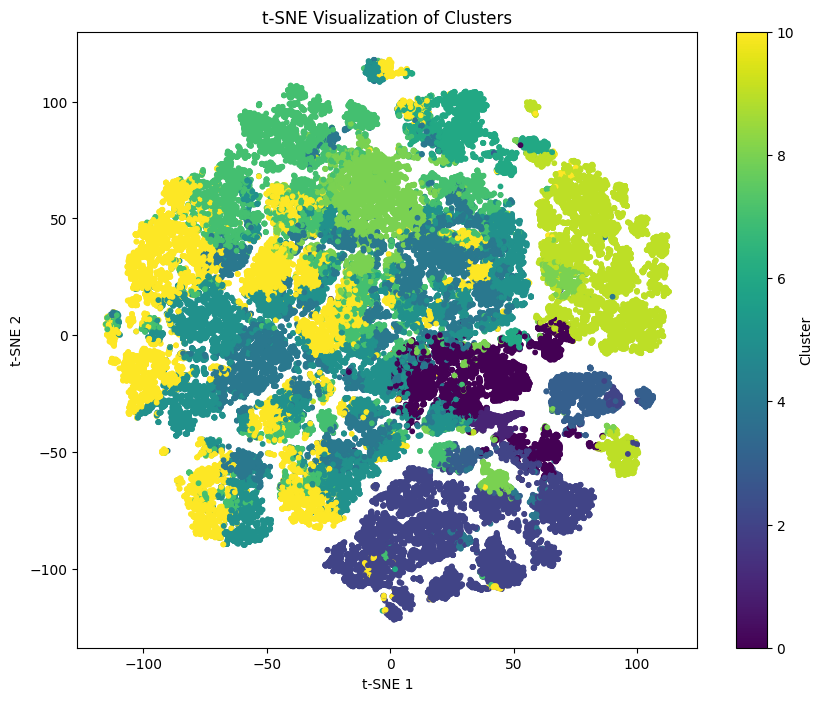

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, random_state=1, perplexity=30, max_iter=1000)
reduced_features = tsne.fit_transform(features)

<positron-console-cell-90>:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.


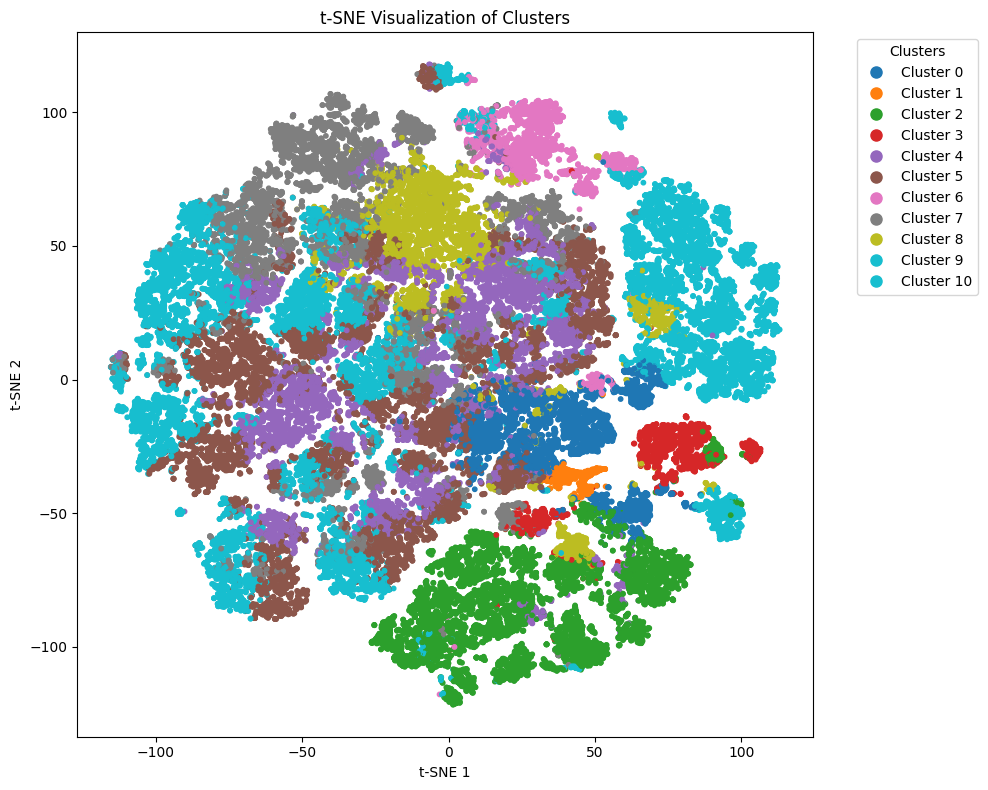

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np

# Define a discrete colormap
unique_labels = np.unique(labels)
num_labels = len(unique_labels)
cmap = plt.cm.get_cmap("tab10", num_labels)  # 'tab10' or 'tab20' are good for discrete colors

# Plot the t-SNE output
plt.figure(figsize=(10, 8))
scatter = plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=labels, cmap=cmap, s=10)

# Add legend with discrete colors
handles = [plt.Line2D([0], [0], marker='o', color=cmap(i), markersize=8, linestyle='', label=f'Cluster {i}') 
           for i in range(num_labels)]
plt.legend(handles=handles, title="Clusters", bbox_to_anchor=(1.05, 1), loc='upper left')

# Add title and labels
plt.title("t-SNE Visualization of Clusters")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.tight_layout()
plt.show()

# CLASSIFICATION

## Logistic Regression

Aggregating 1,2 values of Severity into 0, while 3,4 to 1

We can describe them as:

0. Not Severe Accident
1. Severe Accident

In [ ]:
data = data.withColumn("Severity", when(data["Severity"] == 1, 2).otherwise(data["Severity"]))
data = data.withColumn("Severity", when(data["Severity"] == 4, 3).otherwise(data["Severity"]))
data = data.withColumn("Severity", when(data["Severity"] == 2, 0).otherwise(1))

In [ ]:
data.groupBy("Severity").count().show()

+--------+-----+
|Severity|count|
+--------+-----+
|       1|14481|
|       0|60737|
+--------+-----+

+--------+-----+
|Severity|count|
+--------+-----+
|       1|14481|
|       0|60737|
+--------+-----+



In [ ]:
60737/(14481+60737)

0.8074795926506954

19% of data are of target variable 1, so a model to be at least more accurate than a trivial classifier should ave an accuracy of 0.81

Data are not so unbalanced, so we do not implement balancing in this phase

In [ ]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.sql.types import NumericType

categorical_columns = ["Hour", "Month", "Weather_Condition","Day_of_Week"]

# Indexer and OHE
indexers = [
    StringIndexer(inputCol=col, outputCol=f"{col}_indexed", handleInvalid="skip")
    for col in categorical_columns
]

encoders = [
    OneHotEncoder(inputCol=f"{col}_indexed", outputCol=f"{col}_encoded")
    for col in categorical_columns
]

numerical_columns = [
    field.name for field in data.schema.fields
    if isinstance(field.dataType, NumericType) and field.name not in ["Hour", "Month", "Weather_Condition","Severity","Day_of_Week", "Traffic_Duration",'Wind_Speed(mph)', 'Precipitation(mi)', 'Distance(mi)', 'Visibility(mi)', 'Year','Start_Lat', 'Start_Lng', 'Day_of_Year']
]

feature_columns = numerical_columns + [f"{col}_encoded" for col in categorical_columns]

assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

losgistic_reg = LogisticRegression(featuresCol="features", labelCol="Severity")

pipeline = Pipeline(stages=indexers + encoders + [assembler, losgistic_reg])

# data split
train_data, test_data = data.randomSplit([0.8, 0.2], seed=42)

# fit pipeline
pipeline_model = pipeline.fit(train_data)


In [ ]:
test_data_transformed = pipeline_model.transform(test_data)
evaluator = BinaryClassificationEvaluator(labelCol="Severity", rawPredictionCol="rawPrediction")
accuracy = evaluator.evaluate(test_data_transformed)

# extract logistic regression model
logistic_model = pipeline_model.stages[-1]

#results
print(f"Model Accuracy: {accuracy}")


Model Accuracy: 0.727249529816202
Model Accuracy: 0.727249529816202


The model performs worse than the trivial classifier

### Confusion Matrix

In [ ]:
from pyspark.sql.functions import col, count

predictions_and_labels = test_data_transformed.select(col("Severity").alias("true_label"), col("prediction"))

confusion_matrix_df = (
    predictions_and_labels
    .groupBy("true_label", "prediction")
    .agg(count("*").alias("count"))
    .orderBy("true_label", "prediction")
)

confusion_matrix_df.show()


confusion_matrix_pivot = (
    confusion_matrix_df
    .groupBy("true_label")
    .pivot("prediction")
    .sum("count")
    .fillna(0)
)

confusion_matrix_pivot.show()


+----------+----------+-----+
|true_label|prediction|count|
+----------+----------+-----+
|         0|       0.0|11798|
|         0|       1.0|  156|
|         1|       0.0| 2755|
|         1|       1.0|  156|
+----------+----------+-----+

+----------+----------+-----+
|true_label|prediction|count|
+----------+----------+-----+
|         0|       0.0|11798|
|         0|       1.0|  156|
|         1|       0.0| 2755|
|         1|       1.0|  156|
+----------+----------+-----+



+----------+-----+---+
|true_label|  0.0|1.0|
+----------+-----+---+
|         1| 2744|145|
|         0|11865|150|
+----------+-----+---+

+----------+-----+---+
|true_label|  0.0|1.0|
+----------+-----+---+
|         1| 2744|145|
|         0|11865|150|
+----------+-----+---+



In [ ]:
156/(2755+156)

0.05358983167296462

## Logistic Regression #2

We're also trying to perform logistic regression with severity class 4 (most severe one) as target variable

In [ ]:
# converting the target variable
data = data.withColumn("Severity", when(data["Severity"] == 4, 1).otherwise(0))

plotting the distribution of Severity after the change

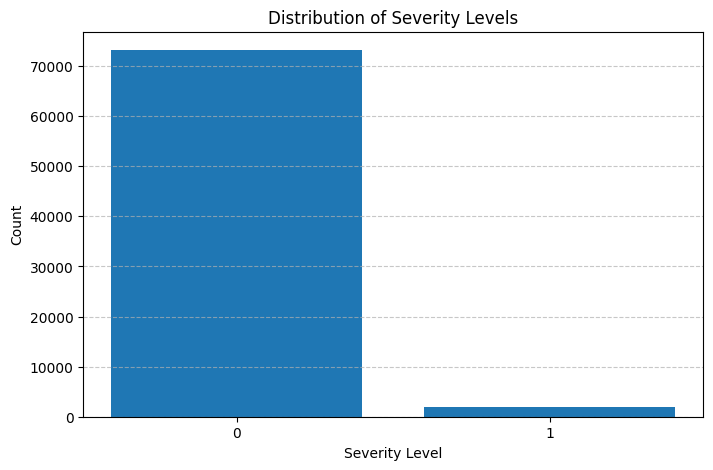

In [ ]:
from pyspark.sql import functions as F

severity_distribution = data.groupBy("Severity").count().orderBy("Severity")

severity_pandas = severity_distribution.toPandas()

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.bar(severity_pandas['Severity'], severity_pandas['count'], tick_label=severity_pandas['Severity'])
plt.title('Distribution of Severity Levels')
plt.xlabel('Severity Level')
plt.ylabel('Count')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [ ]:
data.groupBy("Severity").count().show()

+--------+-----+
|Severity|count|
+--------+-----+
|       1| 1965|
|       0|73253|
+--------+-----+

+--------+-----+
|Severity|count|
+--------+-----+
|       1| 1965|
|       0|73253|
+--------+-----+



In [ ]:
1951/73206

0.026650820970958666

2.66 % of the data is our target class, so a model to be better than the trivial classifier should have at least 0.973 accuracy

We will approach the problem in 2 ways:

1. Unbalanced Learning

2. Balancing the target variable with  random oversampling and undersampling

### Unbalanced Learning

In [ ]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.sql.types import NumericType

categorical_columns = ["Hour", "Month", "Weather_Condition","Day_of_Week"]

#Indexer and OHE
indexers = [
    StringIndexer(inputCol=col, outputCol=f"{col}_indexed", handleInvalid="skip")
    for col in categorical_columns
]

encoders = [
    OneHotEncoder(inputCol=f"{col}_indexed", outputCol=f"{col}_encoded")
    for col in categorical_columns
]

numerical_columns = [
    field.name for field in data.schema.fields
    if isinstance(field.dataType, NumericType) and field.name not in ["Hour", "Month", "Weather_Condition","Severity","Day_of_Week", "Traffic_Duration",'Wind_Speed(mph)', 'Precipitation(mi)', 'Distance(mi)', 'Visibility(mi)', 'Year','Start_Lat', 'Start_Lng', 'Day_of_Year']
]

feature_columns = numerical_columns + [f"{col}_encoded" for col in categorical_columns]

assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

losgistic_reg = LogisticRegression(featuresCol="features", labelCol="Severity")

pipeline = Pipeline(stages=indexers + encoders + [assembler, losgistic_reg])

# data split
train_data, test_data = data.randomSplit([0.8, 0.2], seed=42)


pipeline_model = pipeline.fit(train_data)


In [ ]:
test_data_transformed = pipeline_model.transform(test_data)
evaluator = BinaryClassificationEvaluator(labelCol="Severity", rawPredictionCol="rawPrediction")
accuracy = evaluator.evaluate(test_data_transformed)

logistic_model = pipeline_model.stages[-1]

print(f"Model Accuracy: {accuracy}")


Model Accuracy: 0.7592970242616763
Model Accuracy: 0.7592970242616763


the accuracy is very bad, performing even worse than the trivial classifier

### Confusion Matrix

In [ ]:
from pyspark.sql.functions import col, count

predictions_and_labels = test_data_transformed.select(col("Severity").alias("true_label"), col("prediction"))

confusion_matrix_df = (
    predictions_and_labels
    .groupBy("true_label", "prediction")
    .agg(count("*").alias("count"))
    .orderBy("true_label", "prediction")
)

confusion_matrix_df.show()


confusion_matrix_pivot = (
    confusion_matrix_df
    .groupBy("true_label")
    .pivot("prediction")
    .sum("count")
    .fillna(0)
)

confusion_matrix_pivot.show()

+----------+----------+-----+
|true_label|prediction|count|
+----------+----------+-----+
|         0|       0.0|14478|
|         0|       1.0|    3|
|         1|       0.0|  382|
|         1|       1.0|    2|
+----------+----------+-----+

+----------+----------+-----+
|true_label|prediction|count|
+----------+----------+-----+
|         0|       0.0|14478|
|         0|       1.0|    3|
|         1|       0.0|  382|
|         1|       1.0|    2|
+----------+----------+-----+



+----------+-----+---+
|true_label|  0.0|1.0|
+----------+-----+---+
|         1|  382|  2|
|         0|14478|  3|
+----------+-----+---+

+----------+-----+---+
|true_label|  0.0|1.0|
+----------+-----+---+
|         1|  382|  2|
|         0|14478|  3|
+----------+-----+---+



Let's see if after balancing a bit we can obtain a better result

### Balancing

In [ ]:
severity_counts = data.groupBy("Severity").count()

# count of minority and majority classes
minority_class = severity_counts.orderBy("count").first()["Severity"]
majority_class = severity_counts.orderBy("count", ascending=False).first()["Severity"]

minority_count = severity_counts.filter(col("Severity") == minority_class).first()["count"]
majority_count = severity_counts.filter(col("Severity") == majority_class).first()["count"]

# desired ratio
total_count = minority_count + majority_count
desired_minority_count = int(total_count * 0.25)
desired_majority_count = int(total_count * 0.75)

# oversample
minority_df = data.filter(col("Severity") == minority_class)
oversampled_minority_df = minority_df.sample(withReplacement=True, 
                                             fraction=desired_minority_count / minority_count)

# undersample
majority_df = data.filter(col("Severity") == majority_class)
undersampled_majority_df = majority_df.sample(withReplacement=False, 
                                              fraction=desired_majority_count / majority_count)

# combine
balanced_df = oversampled_minority_df.union(undersampled_majority_df)

balanced_df.groupBy("Severity").count().show()


+--------+-----+
|Severity|count|
+--------+-----+
|       1|18900|
|       0|56279|
+--------+-----+

+--------+-----+
|Severity|count|
+--------+-----+
|       1|18900|
|       0|56279|
+--------+-----+



18907/56429 = 0.335, now nearly 33.5% of data are of class 1 (Severity 4).

Let's rerun the model, the accuracy should be at least 66.5 % to be at least good as the trivial classifier

In [ ]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.sql.types import NumericType


categorical_columns = ["Hour", "Month", "Weather_Condition","Day_of_Week"]

# Indexer and OHE
indexers = [
    StringIndexer(inputCol=col, outputCol=f"{col}_indexed", handleInvalid="skip")
    for col in categorical_columns
]

encoders = [
    OneHotEncoder(inputCol=f"{col}_indexed", outputCol=f"{col}_encoded")
    for col in categorical_columns
]

numerical_columns = [
    field.name for field in data.schema.fields
    if isinstance(field.dataType, NumericType) and field.name not in ["Hour", "Month", "Weather_Condition","Severity","Day_of_Week", "Traffic_Duration",'Wind_Speed(mph)', 'Precipitation(mi)', 'Distance(mi)', 'Visibility(mi)', 'Year','Start_Lat', 'Start_Lng', 'Day_of_Year']
]

feature_columns = numerical_columns + [f"{col}_encoded" for col in categorical_columns]

assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

losgistic_reg = LogisticRegression(featuresCol="features", labelCol="Severity")

pipeline = Pipeline(stages=indexers + encoders + [assembler, losgistic_reg])

train_data, test_data = balanced_df.randomSplit([0.8, 0.2], seed=42)


pipeline_model = pipeline.fit(train_data)


In [ ]:
_, test_data = data.randomSplit([0.8, 0.2], seed=42)

In [ ]:
test_data_transformed = pipeline_model.transform(test_data)
evaluator = BinaryClassificationEvaluator(labelCol="Severity", rawPredictionCol="rawPrediction")
accuracy = evaluator.evaluate(test_data_transformed)

logistic_model = pipeline_model.stages[-1]

print(f"Model Accuracy: {accuracy}")


Model Accuracy: 0.7683878397723423
Model Accuracy: 0.7683878397723423


With the balaned data the accuracy is slightly better, let's look at recall:

### Confusion Matrix

In [ ]:
from pyspark.sql.functions import col, count

predictions_and_labels = test_data_transformed.select(col("Severity").alias("true_label"), col("prediction"))

confusion_matrix_df = (
    predictions_and_labels
    .groupBy("true_label", "prediction")
    .agg(count("*").alias("count"))
    .orderBy("true_label", "prediction")
)

confusion_matrix_df.show()


confusion_matrix_pivot = (
    confusion_matrix_df
    .groupBy("true_label")
    .pivot("prediction")
    .sum("count")
    .fillna(0)
)

confusion_matrix_pivot.show()


+----------+----------+-----+
|true_label|prediction|count|
+----------+----------+-----+
|         0|       0.0|13658|
|         0|       1.0|  873|
|         1|       0.0|  260|
|         1|       1.0|  113|
+----------+----------+-----+

+----------+----------+-----+
|true_label|prediction|count|
+----------+----------+-----+
|         0|       0.0|13658|
|         0|       1.0|  873|
|         1|       0.0|  260|
|         1|       1.0|  113|
+----------+----------+-----+



+----------+-----+---+
|true_label|  0.0|1.0|
+----------+-----+---+
|         1|  268|116|
|         0|13601|880|
+----------+-----+---+

+----------+-----+---+
|true_label|  0.0|1.0|
+----------+-----+---+
|         1|  268|116|
|         0|13601|880|
+----------+-----+---+



In [ ]:
(113)/(113+260)

0.30294906166219837

### Other metrics

In [ ]:
from pyspark.sql.functions import col, count, when, lit, sum as spark_sum

metrics_df = (
    predictions_and_labels
    .withColumn("TP", when((col("true_label") == 1) & (col("prediction") == 1), 1).otherwise(0))
    .withColumn("FP", when((col("true_label") == 0) & (col("prediction") == 1), 1).otherwise(0))
    .withColumn("FN", when((col("true_label") == 1) & (col("prediction") == 0), 1).otherwise(0))
    .withColumn("TN", when((col("true_label") == 0) & (col("prediction") == 0), 1).otherwise(0))
)

aggregated_metrics = metrics_df.agg(
    spark_sum("TP").alias("TP"),
    spark_sum("FP").alias("FP"),
    spark_sum("FN").alias("FN"),
    spark_sum("TN").alias("TN")
).collect()[0]

TP = aggregated_metrics["TP"]
FP = aggregated_metrics["FP"]
FN = aggregated_metrics["FN"]
TN = aggregated_metrics["TN"]

precision = TP / (TP + FP) if (TP + FP) > 0 else 0.0
recall = TP / (TP + FN) if (TP + FN) > 0 else 0.0

print(f"Precision: {precision}")
print(f"Recall: {recall}")


Precision: 0.11646586345381527
Recall: 0.3020833333333333
Precision: 0.11646586345381527
Recall: 0.3020833333333333


### Coefficients Analysis

In [ ]:
training_summary = logistic_model.summary

categorical_feature_names = []

for col in categorical_columns:
    indexer_model = next(
        stage for stage in pipeline_model.stages 
        if stage.__class__.__name__ == "StringIndexerModel" and stage.getInputCol() == col
    )
    
    categories = indexer_model.labels

    categorical_feature_names.extend([f"{col}_{category}" for category in categories[:-1]])  # Exclude the reference category

all_feature_names = numerical_columns + categorical_feature_names

if len(all_feature_names) != len(logistic_model.coefficients):
    print(f"Feature name count ({len(all_feature_names)}) does not match coefficient count ({len(logistic_model.coefficients)})!")
else:
    print("Feature name count matches coefficient count.")

print("\nCoefficients and Features:")
for name, coef in zip(all_feature_names, logistic_model.coefficients):
    print(f"Feature: {name}, Coefficient: {coef}")


Feature name count matches coefficient count.

Coefficients and Features:
Feature: Temperature(F), Coefficient: -0.01779788728959389
Feature: Humidity(%), Coefficient: 0.00294378566655113
Feature: Pressure(in), Coefficient: -0.09491516558576432
Feature: Precipitation(in), Coefficient: 0.012682719195055873
Feature: Amenity, Coefficient: 0.20562997006026945
Feature: Bump, Coefficient: -148.25190981319292
Feature: Crossing, Coefficient: -0.2359585351984123
Feature: Give_Way, Coefficient: 0.36499108359637367
Feature: Junction, Coefficient: -0.011824648657585589
Feature: No_Exit, Coefficient: 0.050891924658823785
Feature: Railway, Coefficient: 0.48199303584339576
Feature: Roundabout, Coefficient: 0.0
Feature: Station, Coefficient: -0.20094885807759458
Feature: Stop, Coefficient: 0.3582460886349248
Feature: Traffic_Calming, Coefficient: -0.7938419770603898
Feature: Traffic_Signal, Coefficient: 0.0029321073407169015
Feature: Civil_Twilight, Coefficient: 0.0824852858178295
Feature: Log_Traffic

### Coef Magnitude

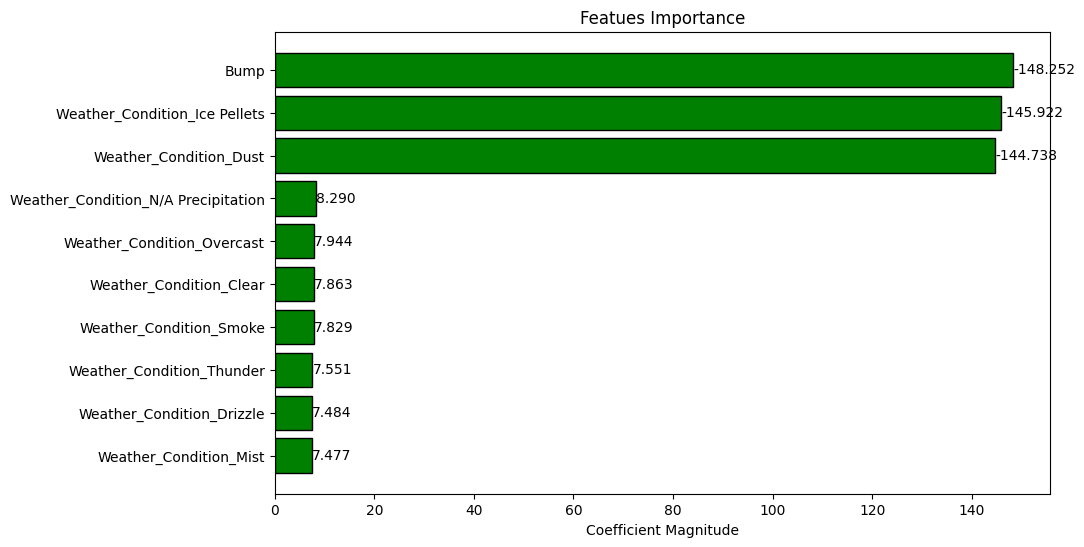

In [ ]:
import matplotlib.pyplot as plt

coef_data = pd.DataFrame({
    "Feature": all_feature_names,
    "Coefficient": logistic_model.coefficients.toArray()
})


coef_data["Abs_Coefficient"] = coef_data["Coefficient"].abs()
coef_data = coef_data.sort_values(by="Abs_Coefficient", ascending=False)
coef_data = coef_data.head(10)

# feature importance
plt.figure(figsize=(10, 6))
bars = plt.barh(coef_data["Feature"], coef_data["Abs_Coefficient"], color="green", edgecolor="black")

# Add text annotations for each bar
for bar, coef in zip(bars, coef_data["Coefficient"]):
    plt.text(
        bar.get_width() + 0.02,  
        bar.get_y() + bar.get_height() / 2,
        f"{coef:.3f}", 
        va='center', 
        fontsize=10  
    )

plt.xlabel("Coefficient Magnitude")
plt.title("Featues Importance")
plt.gca().invert_yaxis()
plt.show()


## Decision Tree

### Task 1

In [ ]:
from pyspark.sql.functions import col, when
from pyspark.ml.feature import VectorAssembler, StringIndexer, StandardScaler, OneHotEncoder
from pyspark.ml.classification import RandomForestClassifier, DecisionTreeClassifier, LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.types import DoubleType, NumericType
from pyspark.ml import Pipeline

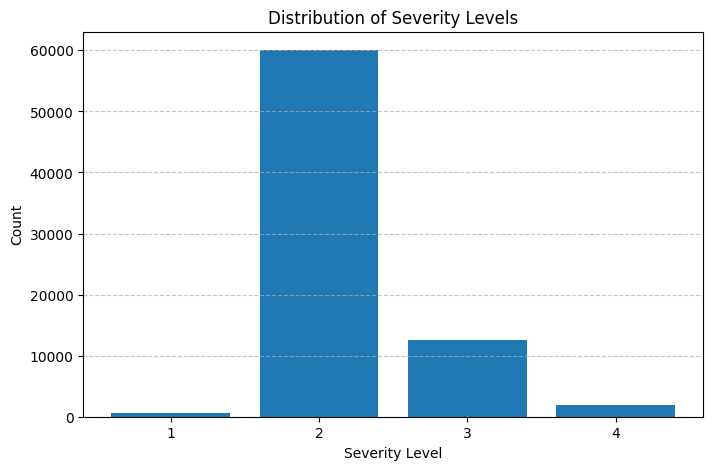

In [ ]:
from pyspark.sql import functions as F

severity_distribution = data.groupBy("Severity").count().orderBy("Severity")

severity_pandas = severity_distribution.toPandas()

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.bar(severity_pandas['Severity'], severity_pandas['count'], tick_label=severity_pandas['Severity'])
plt.title('Distribution of Severity Levels')
plt.xlabel('Severity Level')
plt.ylabel('Count')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

since category 1 of severe accidents is very infrequent we decided to merge category 1 and 2 of severity

In [ ]:
data = data.withColumn("Severity", when(data["Severity"] == 1, 2).otherwise(data["Severity"]))
data = data.withColumn("Severity", when(data["Severity"] == 4, 3).otherwise(data["Severity"]))

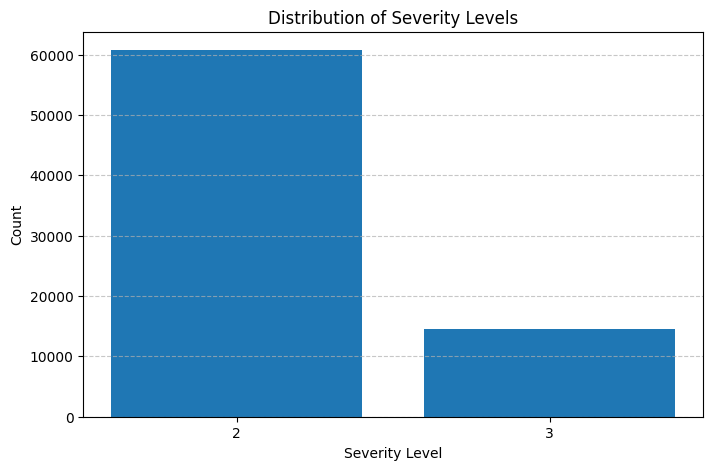

In [ ]:
from pyspark.sql import functions as F

severity_distribution = data.groupBy("Severity").count().orderBy("Severity")

severity_pandas = severity_distribution.toPandas()

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.bar(severity_pandas['Severity'], severity_pandas['count'], tick_label=severity_pandas['Severity'])
plt.title('Distribution of Severity Levels')
plt.xlabel('Severity Level')
plt.ylabel('Count')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [ ]:
data.groupBy("Severity").count().show()

+--------+-----+
|Severity|count|
+--------+-----+
|       3|14481|
|       2|60737|
+--------+-----+

+--------+-----+
|Severity|count|
+--------+-----+
|       3|14481|
|       2|60737|
+--------+-----+



In [ ]:
60737/(60737+14481)

0.8074795926506954

the trivial classifier has an accuracy of 0.81 so we need to overtake this value to have a good model

This is quite an unbalanced learning problem so we first try to solve it by using unbalanced data as they are and then by using some random oversampling and undersampling for balancing

In [ ]:
categorical_columns = ["Hour", "Month", "Weather_Condition","Day_of_Week"]

# Indexer and OHE
indexers = [
    StringIndexer(inputCol=col, outputCol=f"{col}_indexed", handleInvalid="skip")
    for col in categorical_columns
]

encoders = [
    OneHotEncoder(inputCol=f"{col}_indexed", outputCol=f"{col}_encoded")
    for col in categorical_columns
]

numerical_columns = [
    field.name for field in data.schema.fields
    if isinstance(field.dataType, NumericType) and field.name not in ["Hour", "Month", "Weather_Condition","Severity","Day_of_Week", "Traffic_Duration",'Wind_Speed(mph)', 'Precipitation(mi)', 'Distance(mi)', 'Visibility(mi)', 'Year','Start_Lat', 'Start_Lng', 'Day_of_Year']
]

feature_columns = numerical_columns + [f"{col}_encoded" for col in categorical_columns]

assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

pipeline = Pipeline(stages=indexers + encoders + [assembler])

transformed_data = pipeline.fit(data).transform(data)

# transformed_data.show()

In [ ]:
train_data, test_data = transformed_data.randomSplit([0.8, 0.2], seed=42)
train_data, val_data = train_data.randomSplit([0.8, 0.2], seed=42)

### Grid Search

In [ ]:
import random

# hyperparameter
param_grid = {
    "maxDepth": [3, 5, 7, 10, 15],
    "maxBins": [10, 20, 40, 50],
    "minInstancesPerNode": [1, 5, 10],
    "impurity": ["gini", "entropy"]
}

# generate random combinations
def generate_random_params(param_grid, num_combinations=8):
    random_params = []
    for _ in range(num_combinations):
        params = {key: random.choice(values) for key, values in param_grid.items()}
        random_params.append(params)
    return random_params

random_params_list = generate_random_params(param_grid, num_combinations=8)

In [ ]:
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(labelCol="Severity", predictionCol="prediction", metricName="accuracy")

best_model = None
best_accuracy = 0
best_params = None

#loop
for params in random_params_list:
    
    dt = DecisionTreeClassifier(
        featuresCol="features", 
        labelCol="Severity", 
        maxDepth=params["maxDepth"], 
        maxBins=params["maxBins"], 
        minInstancesPerNode=params["minInstancesPerNode"], 
        impurity=params["impurity"]
    )
    
    # train
    model = dt.fit(train_data)
    
    # evaluate
    predictions = model.transform(val_data)
    accuracy = evaluator.evaluate(predictions)
    
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = model
        best_params = params

    print(f"Parameters: {params}")

# Print the best parameters and accuracy
print(f"Best Parameters: {best_params}")
print(f"Best Accuracy: {best_accuracy}")


Parameters: {'maxDepth': 15, 'maxBins': 20, 'minInstancesPerNode': 1, 'impurity': 'entropy'}
Parameters: {'maxDepth': 15, 'maxBins': 20, 'minInstancesPerNode': 1, 'impurity': 'entropy'}


Parameters: {'maxDepth': 5, 'maxBins': 10, 'minInstancesPerNode': 1, 'impurity': 'gini'}
Parameters: {'maxDepth': 5, 'maxBins': 10, 'minInstancesPerNode': 1, 'impurity': 'gini'}


Parameters: {'maxDepth': 3, 'maxBins': 20, 'minInstancesPerNode': 10, 'impurity': 'gini'}
Parameters: {'maxDepth': 3, 'maxBins': 20, 'minInstancesPerNode': 10, 'impurity': 'gini'}


Parameters: {'maxDepth': 3, 'maxBins': 20, 'minInstancesPerNode': 5, 'impurity': 'entropy'}
Parameters: {'maxDepth': 3, 'maxBins': 20, 'minInstancesPerNode': 5, 'impurity': 'entropy'}


Parameters: {'maxDepth': 5, 'maxBins': 40, 'minInstancesPerNode': 5, 'impurity': 'entropy'}
Parameters: {'maxDepth': 5, 'maxBins': 40, 'minInstancesPerNode': 5, 'impurity': 'entropy'}


Parameters: {'maxDepth': 3, 'maxBins': 50, 'minInstancesPerNode': 5, 'impurity': 'gini'}
Parameters: {'maxDepth': 3, 'maxBins': 50, 'minInstancesPerNode': 5, 'impurity': 'gini'}


Parameters: {'maxDepth': 15, 'maxBins': 20, 'minInstancesPerNode': 10, 'impurity': 'gini'}
Parameters: {'maxDepth': 15, 'maxBins': 20, 'minInstancesPerNode': 10, 'impurity': 'gini'}


Parameters: {'maxDepth': 7, 'maxBins': 10, 'minInstancesPerNode': 10, 'impurity': 'entropy'}
Best Parameters: {'maxDepth': 15, 'maxBins': 20, 'minInstancesPerNode': 10, 'impurity': 'gini'}
Best Accuracy: 0.8319851702055949
Parameters: {'maxDepth': 7, 'maxBins': 10, 'minInstancesPerNode': 10, 'impurity': 'entropy'}
Best Parameters: {'maxDepth': 15, 'maxBins': 20, 'minInstancesPerNode': 10, 'impurity': 'gini'}
Best Accuracy: 0.8319851702055949


Running the best model:

In [ ]:
# Evaluate
predictions = best_model.transform(test_data)
accuracy = evaluator.evaluate(predictions)

In [ ]:
accuracy

0.8193773483628556

accuracy of 0.82, equal to the trivial classifier or slightly better

plotting the feature importance:

In [ ]:
pipeline_model = pipeline.fit(data)

In [ ]:
categorical_feature_names = []

for col in categorical_columns:
    # Find the StringIndexerModel corresponding to the current column
    indexer_model = next(
        stage for stage in pipeline_model.stages 
        if stage.__class__.__name__ == "StringIndexerModel" and stage.getInputCol() == col
    )
    
    # Retrieve the categories (labels) from the StringIndexerModel
    categories = indexer_model.labels

    # Adjust for one-hot encoding (one category is omitted)
    categorical_feature_names.extend([f"{col}_{category}" for category in categories[:-1]])  # Exclude the reference category

# Step 3: Combine all feature names
all_feature_names = numerical_columns + categorical_feature_names

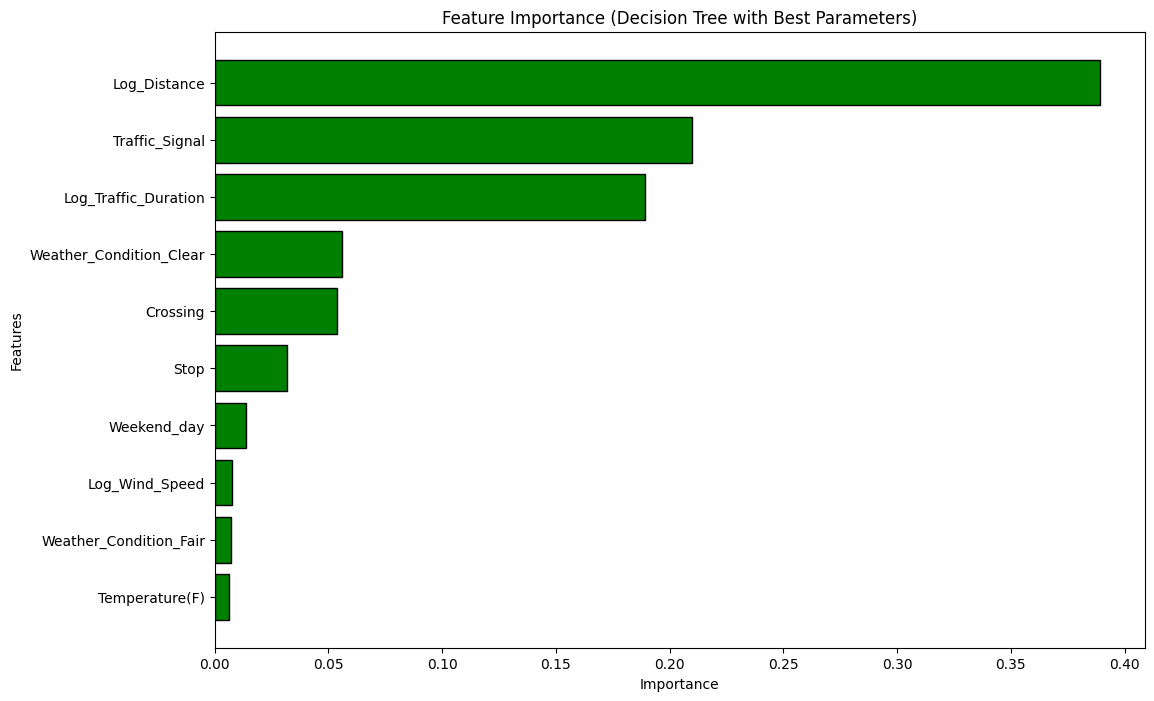

In [ ]:
import pandas as pd

feature_importance = best_model.featureImportances.toArray()

# map features
feature_importance_df = pd.DataFrame({
    "Feature": all_feature_names,
    "Importance": feature_importance
}).sort_values(by="Importance", ascending=False)

feature_importance_df = feature_importance_df[:10]

# feature importance
plt.figure(figsize=(12, 8))
plt.barh(feature_importance_df["Feature"], feature_importance_df["Importance"], color="green", edgecolor="black")
plt.title("Feature Importance (Decision Tree with Best Parameters)")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.gca().invert_yaxis()
plt.show()


In [ ]:
# Confusion Matrix
confusion_matrix = (
    predictions.groupBy("Severity", "prediction")
    .count()
    .orderBy("Severity", "prediction")
)

confusion_matrix.show()


+--------+----------+-----+
|Severity|prediction|count|
+--------+----------+-----+
|       2|       2.0|11137|
|       2|       3.0|  817|
|       3|       2.0| 2114|
|       3|       3.0|  797|
+--------+----------+-----+

+--------+----------+-----+
|Severity|prediction|count|
+--------+----------+-----+
|       2|       2.0|11137|
|       2|       3.0|  817|
|       3|       2.0| 2114|
|       3|       3.0|  797|
+--------+----------+-----+



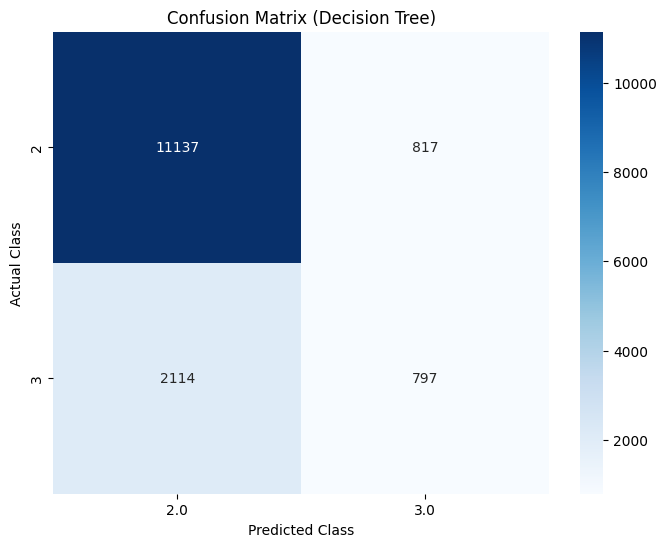

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

confusion_matrix_df = confusion_matrix.toPandas()

pivot_cm = confusion_matrix_df.pivot(index="Severity", columns="prediction", values="count").fillna(0)

plt.figure(figsize=(8, 6))
sns.heatmap(pivot_cm, annot=True, fmt="g", cmap="Blues")

plt.title("Confusion Matrix (Decision Tree)")
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")
plt.show()


In [ ]:
predictions_pandas = predictions.select("Severity", "prediction").toPandas()

from sklearn.metrics import classification_report

y_true = predictions_pandas["Severity"]
y_pred = predictions_pandas["prediction"]

report = classification_report(y_true, y_pred, target_names=["Class 2", "Class 3"])
print(report)


              precision    recall  f1-score   support

     Class 2       0.84      0.93      0.88     11954
     Class 3       0.49      0.27      0.35      2911

    accuracy                           0.80     14865
   macro avg       0.67      0.60      0.62     14865
weighted avg       0.77      0.80      0.78     14865

              precision    recall  f1-score   support

     Class 2       0.84      0.93      0.88     11954
     Class 3       0.49      0.27      0.35      2911

    accuracy                           0.80     14865
   macro avg       0.67      0.60      0.62     14865
weighted avg       0.77      0.80      0.78     14865



## Decision Tree # 2

Now we are trying to solve the same problem as Logistic Regression #2, using the same balanced data. The target variable class here is Severity 4

In [ ]:
from pyspark.sql.functions import when, col
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.sql.types import NumericType

In [ ]:
# converting the target variable
data = data.withColumn("Severity", when(data["Severity"] == 4, 1).otherwise(0))

### Unbalanced Learning

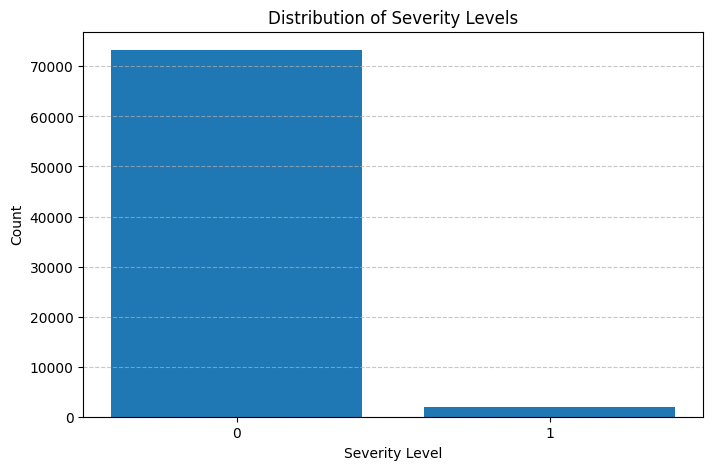

In [ ]:
from pyspark.sql import functions as F

severity_distribution = data.groupBy("Severity").count().orderBy("Severity")

severity_pandas = severity_distribution.toPandas()

# Plot the distribution
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.bar(severity_pandas['Severity'], severity_pandas['count'], tick_label=severity_pandas['Severity'])
plt.title('Distribution of Severity Levels')
plt.xlabel('Severity Level')
plt.ylabel('Count')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [ ]:
data.groupBy("Severity").count().show()

+--------+-----+
|Severity|count|
+--------+-----+
|       1| 1965|
|       0|73253|
+--------+-----+

+--------+-----+
|Severity|count|
+--------+-----+
|       1| 1965|
|       0|73253|
+--------+-----+



In [ ]:
73253/(73253+1965)

0.9738759339519796

the trivial classifier has an accuracy of 0.97 so we need to overtake this value to have a good model

In [ ]:
categorical_columns = ["Hour", "Month", "Weather_Condition","Day_of_Week"]

indexers = [
    StringIndexer(inputCol=col, outputCol=f"{col}_indexed", handleInvalid="skip")
    for col in categorical_columns
]

encoders = [
    OneHotEncoder(inputCol=f"{col}_indexed", outputCol=f"{col}_encoded")
    for col in categorical_columns
]

numerical_columns = [
    field.name for field in data.schema.fields
    if isinstance(field.dataType, NumericType) and field.name not in ["Hour", "Month", "Weather_Condition","Severity","Day_of_Week", "Traffic_Duration",'Wind_Speed(mph)', 'Precipitation(mi)', 'Distance(mi)', 'Visibility(mi)', 'Year','Start_Lat', 'Start_Lng', 'Day_of_Year']
]

feature_columns = numerical_columns + [f"{col}_encoded" for col in categorical_columns]

assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

pipeline = Pipeline(stages=indexers + encoders + [assembler])

transformed_data = pipeline.fit(data).transform(data)

# transformed_data.show()

In [ ]:
train_data, test_data = transformed_data.randomSplit([0.8, 0.2], seed=42)
train_data, val_data = train_data.randomSplit([0.8, 0.2], seed=42)

### Grid Search

In [ ]:
import random

# hyperparameter space
param_grid = {
    "maxDepth": [3, 5, 7, 10, 15],
    "maxBins": [10, 20, 40, 50],
    "minInstancesPerNode": [1, 5, 10],
    "impurity": ["gini", "entropy"]
}

# generate random combinations of hyperparameters
def generate_random_params(param_grid, num_combinations=8):
    random_params = []
    for _ in range(num_combinations):
        params = {key: random.choice(values) for key, values in param_grid.items()}
        random_params.append(params)
    return random_params

random_params_list = generate_random_params(param_grid, num_combinations=8)

In [ ]:
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(labelCol="Severity", predictionCol="prediction", metricName="accuracy")

best_model = None
best_accuracy = 0
best_params = None

#loop
for params in random_params_list:

    dt = DecisionTreeClassifier(
        featuresCol="features", 
        labelCol="Severity", 
        maxDepth=params["maxDepth"], 
        maxBins=params["maxBins"], 
        minInstancesPerNode=params["minInstancesPerNode"], 
        impurity=params["impurity"]
    )
    
    # train
    model = dt.fit(train_data)
    
    # evaluate
    predictions = model.transform(val_data)
    accuracy = evaluator.evaluate(predictions)
    
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = model
        best_params = params

    print(f"Parameters: {params}")

# Print the best parameters and accuracy
print(f"Best Parameters: {best_params}")
print(f"Best Accuracy: {best_accuracy}")


Parameters: {'maxDepth': 5, 'maxBins': 40, 'minInstancesPerNode': 1, 'impurity': 'entropy'}
Parameters: {'maxDepth': 5, 'maxBins': 40, 'minInstancesPerNode': 1, 'impurity': 'entropy'}


Parameters: {'maxDepth': 5, 'maxBins': 20, 'minInstancesPerNode': 10, 'impurity': 'entropy'}
Parameters: {'maxDepth': 5, 'maxBins': 20, 'minInstancesPerNode': 10, 'impurity': 'entropy'}


Parameters: {'maxDepth': 7, 'maxBins': 10, 'minInstancesPerNode': 10, 'impurity': 'gini'}
Parameters: {'maxDepth': 7, 'maxBins': 10, 'minInstancesPerNode': 10, 'impurity': 'gini'}


Parameters: {'maxDepth': 3, 'maxBins': 50, 'minInstancesPerNode': 10, 'impurity': 'gini'}
Parameters: {'maxDepth': 3, 'maxBins': 50, 'minInstancesPerNode': 10, 'impurity': 'gini'}


Parameters: {'maxDepth': 5, 'maxBins': 20, 'minInstancesPerNode': 1, 'impurity': 'entropy'}
Parameters: {'maxDepth': 5, 'maxBins': 20, 'minInstancesPerNode': 1, 'impurity': 'entropy'}


Parameters: {'maxDepth': 7, 'maxBins': 10, 'minInstancesPerNode': 1, 'impurity': 'gini'}
Parameters: {'maxDepth': 7, 'maxBins': 10, 'minInstancesPerNode': 1, 'impurity': 'gini'}


Parameters: {'maxDepth': 5, 'maxBins': 50, 'minInstancesPerNode': 10, 'impurity': 'gini'}
Parameters: {'maxDepth': 5, 'maxBins': 50, 'minInstancesPerNode': 10, 'impurity': 'gini'}


Parameters: {'maxDepth': 3, 'maxBins': 20, 'minInstancesPerNode': 1, 'impurity': 'entropy'}
Best Parameters: {'maxDepth': 5, 'maxBins': 20, 'minInstancesPerNode': 10, 'impurity': 'entropy'}
Best Accuracy: 0.9754070841027362
Parameters: {'maxDepth': 3, 'maxBins': 20, 'minInstancesPerNode': 1, 'impurity': 'entropy'}
Best Parameters: {'maxDepth': 5, 'maxBins': 20, 'minInstancesPerNode': 10, 'impurity': 'entropy'}
Best Accuracy: 0.9754070841027362


Running the best model:

In [ ]:
# evaluate
predictions = best_model.transform(test_data)
accuracy = evaluator.evaluate(predictions)

In [ ]:
accuracy

0.9749731615673645

0.975, slightly better than trivial classifier, let's see if with balancing the model improves

In [ ]:
dt = DecisionTreeClassifier(
    featuresCol="features", 
    labelCol="Severity", 
    maxDepth=20, 
    maxBins=20, 
    minInstancesPerNode=10, 
    impurity='entropy'
)

# train
model = dt.fit(train_data)

# evaluate
predictions = model.transform(test_data)
accuracy = evaluator.evaluate(predictions)

In [ ]:
accuracy

0.9727589908749329

Plottin feature importance of the best model (unbalanced one):

In [ ]:
pipeline_model = pipeline.fit(data)

In [ ]:
from pyspark.ml.feature import VectorAssembler

# Get the feature names from the assembler's metadata
assembler = next(stage for stage in pipeline_model.stages if isinstance(stage, VectorAssembler))
feature_metadata = assembler.getOutputCol()
vector_metadata = transformed_data.schema[feature_metadata].metadata["ml_attr"]["attrs"]

# Combine categorical and numeric feature names
all_feature_names = []
if "numeric" in vector_metadata:
    all_feature_names.extend(attr["name"] for attr in vector_metadata["numeric"])
if "binary" in vector_metadata:
    all_feature_names.extend(attr["name"] for attr in vector_metadata["binary"])

# Verify length alignment
print(f"Number of Features: {len(all_feature_names)}")
print(f"Number of Feature Importances: {len(model.featureImportances)}")


Number of Features: 82
Number of Feature Importances: 82
Number of Features: 82
Number of Feature Importances: 82


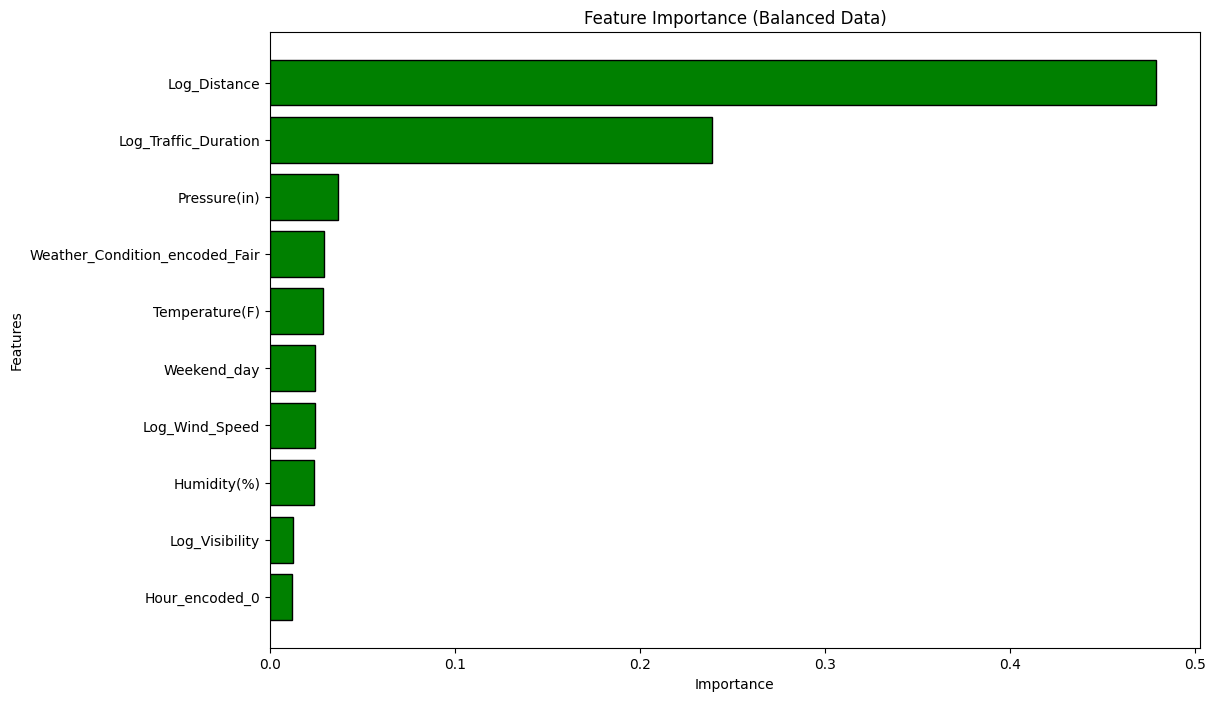

In [ ]:
import pandas as pd

# Extract feature importances
feature_importance = model.featureImportances.toArray()

# Align feature names with importances
feature_importance_df = pd.DataFrame({
    "Feature": all_feature_names,
    "Importance": feature_importance
}).sort_values(by="Importance", ascending=False)

# Plot top features
top_features = feature_importance_df[:10]
plt.figure(figsize=(12, 8))
plt.barh(top_features["Feature"], top_features["Importance"], color="green", edgecolor="black")
plt.title("Feature Importance (Balanced Data)")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.gca().invert_yaxis()
plt.show()


In [ ]:
confusion_matrix = (
    predictions.groupBy("Severity", "prediction")
    .count()
    .orderBy("Severity", "prediction")
)

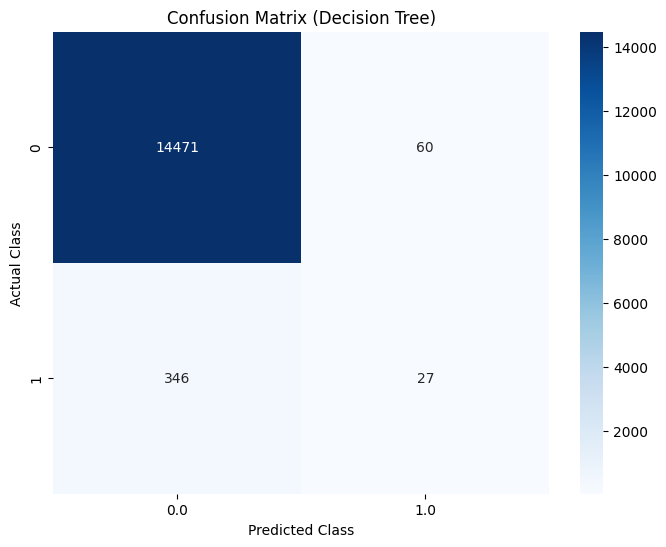

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

confusion_matrix_df = confusion_matrix.toPandas()

pivot_cm = confusion_matrix_df.pivot(index="Severity", columns="prediction", values="count").fillna(0)

plt.figure(figsize=(8, 6))
sns.heatmap(pivot_cm, annot=True, fmt="g", cmap="Blues")

plt.title("Confusion Matrix (Decision Tree)")
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")
plt.show()


In [ ]:
predictions_pandas = predictions.select("Severity", "prediction").toPandas()

from sklearn.metrics import classification_report

y_true = predictions_pandas["Severity"]
y_pred = predictions_pandas["prediction"]

report = classification_report(y_true, y_pred, target_names=["Class 1, 2, 3", "Class 4"])
print(report)


               precision    recall  f1-score   support

Class 1, 2, 3       0.98      1.00      0.99     14531
      Class 4       0.31      0.07      0.12       373

     accuracy                           0.97     14904
    macro avg       0.64      0.53      0.55     14904
 weighted avg       0.96      0.97      0.96     14904

               precision    recall  f1-score   support

Class 1, 2, 3       0.98      1.00      0.99     14531
      Class 4       0.31      0.07      0.12       373

     accuracy                           0.97     14904
    macro avg       0.64      0.53      0.55     14904
 weighted avg       0.96      0.97      0.96     14904



### Balancing:

In [ ]:
severity_counts = data.groupBy("Severity").count()

minority_class = severity_counts.orderBy("count").first()["Severity"]
majority_class = severity_counts.orderBy("count", ascending=False).first()["Severity"]

minority_count = severity_counts.filter(col("Severity") == minority_class).first()["count"]
majority_count = severity_counts.filter(col("Severity") == majority_class).first()["count"]

# desired ratio
total_count = minority_count + majority_count
desired_minority_count = int(total_count * 0.25)
desired_majority_count = int(total_count * 0.75)

# oversample
minority_df = data.filter(col("Severity") == minority_class)
oversampled_minority_df = minority_df.sample(withReplacement=True, 
                                             fraction=desired_minority_count / minority_count)

# undersample
majority_df = data.filter(col("Severity") == majority_class)
undersampled_majority_df = majority_df.sample(withReplacement=False, 
                                              fraction=desired_majority_count / majority_count)

#combine
balanced_df = oversampled_minority_df.union(undersampled_majority_df)

balanced_df.groupBy("Severity").count().show()


+--------+-----+
|Severity|count|
+--------+-----+
|       1|18836|
|       0|56280|
+--------+-----+

+--------+-----+
|Severity|count|
+--------+-----+
|       1|18836|
|       0|56280|
+--------+-----+



In [ ]:
18772/56372

0.33300219967359684

the percentage of minority class is the same as Logistic Regression # 2 Model: 33.4%

In [ ]:
categorical_columns = ["Hour", "Month", "Weather_Condition","Day_of_Week"]

# Indexer and OHE
indexers = [
    StringIndexer(inputCol=col, outputCol=f"{col}_indexed", handleInvalid="skip")
    for col in categorical_columns
]

encoders = [
    OneHotEncoder(inputCol=f"{col}_indexed", outputCol=f"{col}_encoded")
    for col in categorical_columns
]

numerical_columns = [
    field.name for field in data.schema.fields
    if isinstance(field.dataType, NumericType) and field.name not in ["Hour", "Month", "Weather_Condition","Severity","Day_of_Week", "Traffic_Duration",'Wind_Speed(mph)', 'Precipitation(mi)', 'Distance(mi)', 'Visibility(mi)', 'Year','Start_Lat', 'Start_Lng', 'Day_of_Year']
]

feature_columns = numerical_columns + [f"{col}_encoded" for col in categorical_columns]

assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

pipeline = Pipeline(stages=indexers + encoders + [assembler])

transformed_data = pipeline.fit(balanced_df).transform(balanced_df)

# transformed_data.show()

In [ ]:
train_data, test_data = transformed_data.randomSplit([0.8, 0.2], seed=42)
train_data, val_data = train_data.randomSplit([0.8, 0.2], seed=42)

### Grid Search

In [ ]:
import random

# hyperparameter space
param_grid = {
    "maxDepth": [5, 10, 15, 20],
    "maxBins": [10, 20, 50],
    "minInstancesPerNode": [100, 500, 1000],
    "impurity": ["gini", "entropy"]
}

# generate random combinations of hyperparameters
def generate_random_params(param_grid, num_combinations=8):
    random_params = []
    for _ in range(num_combinations):
        params = {key: random.choice(values) for key, values in param_grid.items()}
        random_params.append(params)
    return random_params

random_params_list = generate_random_params(param_grid, num_combinations=8)

In [ ]:
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(labelCol="Severity", predictionCol="prediction", metricName="accuracy")

best_model = None
best_accuracy = 0
best_params = None

for params in random_params_list:

    dt = DecisionTreeClassifier(
        featuresCol="features", 
        labelCol="Severity", 
        maxDepth=params["maxDepth"], 
        maxBins=params["maxBins"], 
        minInstancesPerNode=params["minInstancesPerNode"], 
        impurity=params["impurity"]
    )
    
    # train
    model = dt.fit(train_data)
    
    # evaluate
    predictions = model.transform(val_data)
    accuracy = evaluator.evaluate(predictions)
    
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = model
        best_params = params

    print(f"Parameters: {params}")

# Print the best parameters and accuracy
print(f"Best Parameters: {best_params}")
print(f"Best Accuracy: {best_accuracy}")


Parameters: {'maxDepth': 15, 'maxBins': 20, 'minInstancesPerNode': 1000, 'impurity': 'entropy'}
Parameters: {'maxDepth': 15, 'maxBins': 20, 'minInstancesPerNode': 1000, 'impurity': 'entropy'}


Parameters: {'maxDepth': 5, 'maxBins': 10, 'minInstancesPerNode': 100, 'impurity': 'gini'}
Parameters: {'maxDepth': 5, 'maxBins': 10, 'minInstancesPerNode': 100, 'impurity': 'gini'}


Parameters: {'maxDepth': 20, 'maxBins': 50, 'minInstancesPerNode': 1000, 'impurity': 'gini'}
Parameters: {'maxDepth': 20, 'maxBins': 50, 'minInstancesPerNode': 1000, 'impurity': 'gini'}


Parameters: {'maxDepth': 20, 'maxBins': 50, 'minInstancesPerNode': 100, 'impurity': 'entropy'}
Parameters: {'maxDepth': 20, 'maxBins': 50, 'minInstancesPerNode': 100, 'impurity': 'entropy'}


Parameters: {'maxDepth': 10, 'maxBins': 50, 'minInstancesPerNode': 500, 'impurity': 'entropy'}
Parameters: {'maxDepth': 10, 'maxBins': 50, 'minInstancesPerNode': 500, 'impurity': 'entropy'}


Parameters: {'maxDepth': 5, 'maxBins': 20, 'minInstancesPerNode': 1000, 'impurity': 'gini'}
Parameters: {'maxDepth': 5, 'maxBins': 20, 'minInstancesPerNode': 1000, 'impurity': 'gini'}


Parameters: {'maxDepth': 5, 'maxBins': 50, 'minInstancesPerNode': 500, 'impurity': 'gini'}
Parameters: {'maxDepth': 5, 'maxBins': 50, 'minInstancesPerNode': 500, 'impurity': 'gini'}


Parameters: {'maxDepth': 15, 'maxBins': 20, 'minInstancesPerNode': 1000, 'impurity': 'entropy'}
Best Parameters: {'maxDepth': 20, 'maxBins': 50, 'minInstancesPerNode': 100, 'impurity': 'entropy'}
Best Accuracy: 0.8238946220320497
Parameters: {'maxDepth': 15, 'maxBins': 20, 'minInstancesPerNode': 1000, 'impurity': 'entropy'}
Best Parameters: {'maxDepth': 20, 'maxBins': 50, 'minInstancesPerNode': 100, 'impurity': 'entropy'}
Best Accuracy: 0.8238946220320497


In [ ]:
dt = DecisionTreeClassifier(
    featuresCol="features", 
    labelCol="Severity", 
    maxDepth=20, 
    maxBins=50, 
    minInstancesPerNode=100, 
    impurity='entropy'
)

# train
model = dt.fit(train_data)

In [ ]:
transformed_data = pipeline.fit(data).transform(data)

In [ ]:
_, test_data = transformed_data.randomSplit([0.8, 0.2], seed=42)

In [ ]:
# evaluate
predictions = model.transform(test_data)
accuracy = evaluator.evaluate(predictions)

print(f"Accuracy: {accuracy}")

Accuracy: 0.9007648953301127
Accuracy: 0.9007648953301127


Accuracy on test set reached 0.926, that is worse than the trivial classifier: 0.97

In [ ]:
pipeline_model = pipeline.fit(data)

In [ ]:
from pyspark.ml.feature import VectorAssembler

# Get the feature names from the assembler's metadata
assembler = next(stage for stage in pipeline_model.stages if isinstance(stage, VectorAssembler))
feature_metadata = assembler.getOutputCol()
vector_metadata = transformed_data.schema[feature_metadata].metadata["ml_attr"]["attrs"]

# Combine categorical and numeric feature names
all_feature_names = []
if "numeric" in vector_metadata:
    all_feature_names.extend(attr["name"] for attr in vector_metadata["numeric"])
if "binary" in vector_metadata:
    all_feature_names.extend(attr["name"] for attr in vector_metadata["binary"])

# Verify length alignment
print(f"Number of Features: {len(all_feature_names)}")
print(f"Number of Feature Importances: {len(model.featureImportances)}")


Number of Features: 82
Number of Feature Importances: 82
Number of Features: 82
Number of Feature Importances: 82


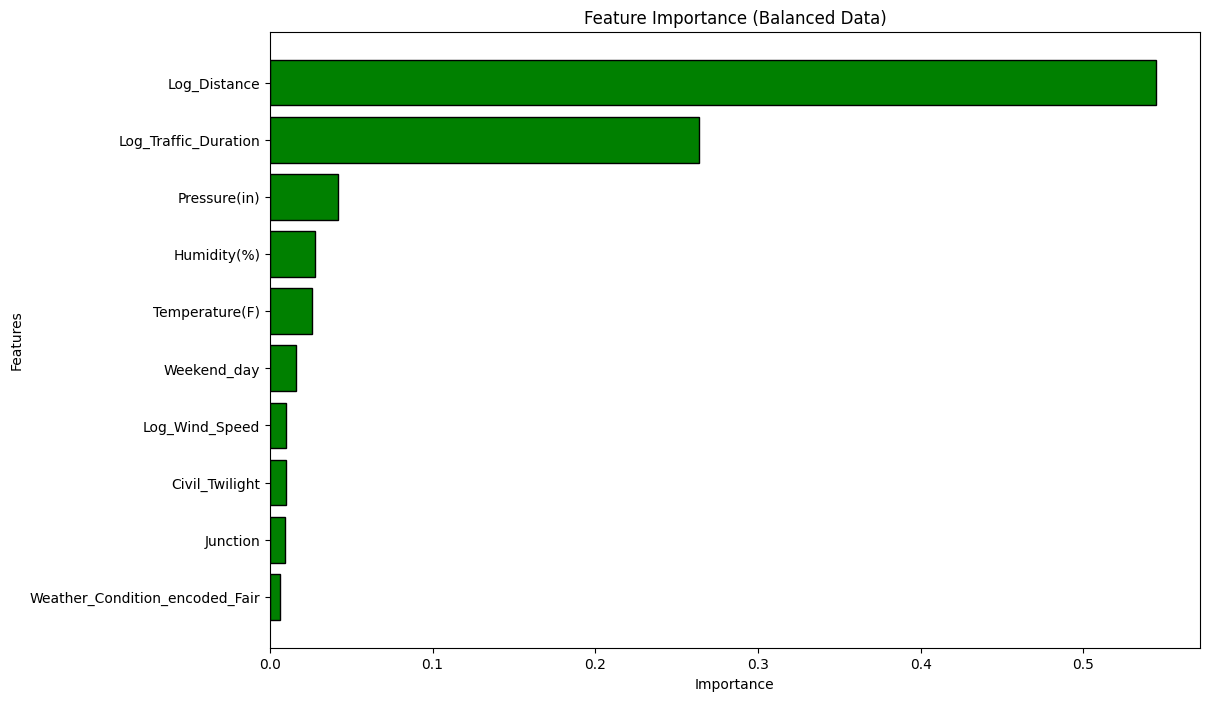

In [ ]:
import pandas as pd

# Extract feature importances
feature_importance = model.featureImportances.toArray()

# Align feature names with importances
feature_importance_df = pd.DataFrame({
    "Feature": all_feature_names,
    "Importance": feature_importance
}).sort_values(by="Importance", ascending=False)

# Plot top features
top_features = feature_importance_df[:10]
plt.figure(figsize=(12, 8))
plt.barh(top_features["Feature"], top_features["Importance"], color="green", edgecolor="black")
plt.title("Feature Importance (Balanced Data)")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.gca().invert_yaxis()
plt.show()


In [ ]:
confusion_matrix = (
    predictions.groupBy("Severity", "prediction")
    .count()
    .orderBy("Severity", "prediction")
)

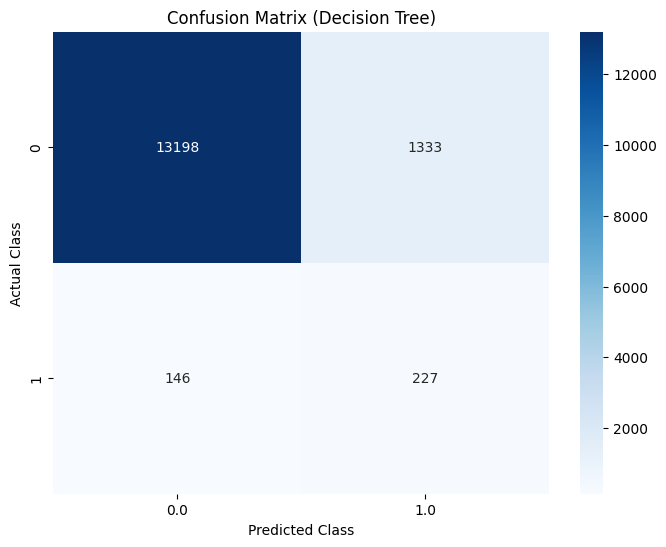

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

confusion_matrix_df = confusion_matrix.toPandas()

pivot_cm = confusion_matrix_df.pivot(index="Severity", columns="prediction", values="count").fillna(0)

# heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(pivot_cm, annot=True, fmt="g", cmap="Blues")


plt.title("Confusion Matrix (Decision Tree)")
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")
plt.show()

In [ ]:
predictions_pandas = predictions.select("Severity", "prediction").toPandas()

from sklearn.metrics import classification_report

y_true = predictions_pandas["Severity"]
y_pred = predictions_pandas["prediction"]

report = classification_report(y_true, y_pred, target_names=["Class 1, 2, 3", "Class 4"])
print(report)


               precision    recall  f1-score   support

Class 1, 2, 3       0.99      0.91      0.95     14531
      Class 4       0.15      0.61      0.23       373

     accuracy                           0.90     14904
    macro avg       0.57      0.76      0.59     14904
 weighted avg       0.97      0.90      0.93     14904

               precision    recall  f1-score   support

Class 1, 2, 3       0.99      0.91      0.95     14531
      Class 4       0.15      0.61      0.23       373

     accuracy                           0.90     14904
    macro avg       0.57      0.76      0.59     14904
 weighted avg       0.97      0.90      0.93     14904



## Final Consideration

Finally we can assert that the best achieved model is the Decision Tree on balanced data, with target class the Severity '4'.

Balancing has been achieved with both random  undersampling and oversampling.

This model managed to achieve a value for accuracy of 0.82, better than the trivial one (that predicts always classes 1,2,3): 0.665, and also better than the Logistic Regression Model performed on the same task: 0.77

Features Importance show how the most important characteristics of a severe accident is the distance affected by the accidents and the Traffic duration generated. Among the categorical features, the most important ones are fair and cloudy weather condition. Our hypotesis is that with fair weather condition drivers tend to keep a high speed, increasing the probability of a severe accident. With avverse weather condition instead is probable that people drive carefully.

This interpretation could help us also explaining the 3rd place in the rank of feature importance for 'Pressure(in)'. In fact high-pressure zones are usually characterize by good weather. Maybe for this reason 'Pressure(in)' helps so much in predictions

# STOPPING CONTEXT

In [755]:
spark.stop()